In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install climetlab

In [ ]:
!echo -e "url: https://cds.climate.copernicus.eu/api/v2\nkey: 88370:410dba58-e4df-4e07-9a78-30b9db798487" > /root/.cdsapirc

In [ ]:
import climetlab as cml

# Imports

15.128  - UV visible albedo for direct radiation - aluvp \\
16.128  - UV visible albedo for diffuse radiation - aluvd \\
17.128  - Near IR albedo for direct radiation - alnip \\
18.128  - Near IR albedo for diffuse radiation - alnid \\
26.128  - Lake cover (new at cycle 41r1) - cl \\
27.128  - Low vegetation cover - cvl \\
28.128  - High vegetation cover - cvh \\
43.128  - Soil type - slt \\
74.128  - Standard deviation of filtered subgrid orography - sdfor \\
129.128 - Geopotential (at the surface orograpphy *g) - z \\
134.128 - Surface pressure - sp \\
141.128 - Snow depth (used also for glaciers =10) - sd \\
160.128 - Standard deviation of orography - sdor \\
161.128 - Anisotropy of sub-gridscale orography - isor \\
162.128 - Angle of sub-gridscale orography - anor \\
163.128 - Slope of sub-gridscale orography - slor \\
172.128 - Land-sea mask - lsm \\
228.128 - Total precipitation - tp \\
243.128 - Forecast albedo - fal \\

7.228 - Lake depth  \\

35.235  - Mean surface downward short-wave radiation flux \\
36.235  - Mean surface downward long-wave radiation flux \\

128.254 - 2m temperature \\
129.254 - 2m dewpoint temperature \\
130.254 - 10m u-component of wind \\
131.254 - 10m v-component of wind \\


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor

In [3]:
def get_plot(lst_final_df, loc, year, month, pred_cols=['pred_lr','pred_dt','pred_rf', 'pred_xgb', 'pred_nn'], gt='LST_Day_1km_Max_mean'):
  if month == '02':
    month_name = 'Feb'
  else:
    month_name = 'Aug'

  df = lst_final_df[lst_final_df['Year'] == year][lst_final_df['Month'] == month][lst_final_df['Location'] == loc]
  dates = df['Day'].apply(lambda x : str(x))

  plt.figure(figsize=(15, 10))

  color = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
  color_cnt = 0
  
  for i, col in enumerate(pred_cols): 
    plt.plot(dates, df[col], c=color[i], linestyle='--', marker='o', label=col)
  plt.scatter(dates, df[gt], c='k', marker='o', zorder=20, label=gt)
  # if era5: 
  #   plt.scatter(dates, df[era5], c='r', marker='^', zorder=20, label=era5)

  plt.xlabel('Date of the month')
  plt.ylabel('Temperature (in K)')
  plt.legend()
  plt.title(f'MODIS LST Daily vs. Predicted Skin Temperature ({loc}, {month_name} {year})')

  plt.grid(zorder=0)
  plt.show()

# Download via climetlab

In [ ]:
def get_data_lat_lon(df, lat, long, variables):
  temp_df = df.loc[df["latitude"] == lat]
  temp_df = temp_df.loc[temp_df["longitude"]==long]
  return temp_df[variables]

In [ ]:
# https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation (Variable names)

# variables = ['10m_u_component_of_wind',  '10m_v_component_of_wind', '2m_dewpoint_temperature',
#             '2m_temperature', 'angle_of_sub_gridscale_orography', 'anisotropy_of_sub_gridscale_orography',
#             'forecast_albedo', 'high_vegetation_cover', 'lake_cover',
#             'lake_depth', 'land_sea_mask', 'low_vegetation_cover',
#             'mean_surface_downward_long_wave_radiation_flux', 'mean_surface_downward_short_wave_radiation_flux', 'near_ir_albedo_for_diffuse_radiation',
#             'near_ir_albedo_for_direct_radiation', 'orography', 'slope_of_sub_gridscale_orography',
#             'snow_albedo', 'snow_depth', 'soil_type',
#             'standard_deviation_of_filtered_subgrid_orography', 'surface_pressure', 'total_precipitation',
#             'uv_visible_albedo_for_diffuse_radiation', 'uv_visible_albedo_for_direct_radiation',]

variables = ['skin_temperature']


area = [72.250, -27, 11, 64]
months = ['02','08']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
# years = ['2005', '2006', '2007', '2008', '2009',]
# years =  ['2010', '2011', '2012', '2013', '2014',]
# years = ['2015', '2016', '2017', '2018', '2019',]
# years =  ['2020', '2021',]
days = ['01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12',
        '13', '14', '15',
        '16', '17', '18',
        '19', '20', '21',
        '22', '23', '24',
        '25', '26', '27',
        '28', '29', '30',
        '31',]
time= ["12:00", "13:00", "14:00", "15:00", "16:00", "17:00"]

source = cml.load_source("cds",
                         "reanalysis-era5-single-levels",
                         variable=variables,
                         area=area,
                         product_type= "reanalysis",
                         month=months,
                         year=years,
                         day=days,
                         time=time)

2021-06-16 15:35:15,551 INFO Welcome to the CDS
2021-06-16 15:35:15,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2021-06-16 15:35:15,695 INFO Request is queued
2021-06-16 15:35:16,791 INFO Request is running
2021-06-16 15:47:36,666 INFO Request is completed
2021-06-16 15:47:36,669 INFO Downloading https://download-0004.copernicus-climate.eu/cache-compute-0004/cache/data8/adaptor.mars.internal-1623857716.082255-26036-1-e8fba314-3751-43fe-afa3-50a13ce02a6c.grib to /tmp/climetlab-root/cdsretriever-d8755d8769d299fbddc464c7b49b076dff69dcb67da1db296820cc42b9502bf0.cache.tmp (1.3G)
2021-06-16 15:49:32,424 INFO Download rate 11.1M/s


In [ ]:
# for s in source:
#     cml.plot_map(s,
#                  foreground=dict(
#                       map_grid=True,
#                       map_label=True,
#                       map_grid_frame=True,
#                       map_grid_frame_thickness=5,
#                       map_boundaries=True,
#                   ),)

In [ ]:
data = source.to_xarray()
df = data.to_dataframe()
df.reset_index(inplace=True)
df.head(100)

In [ ]:
df.to_csv("era5_data_10m_u_component_of_wind_feb_2020_2021.csv", index=False)

In [ ]:
!cp ./era5_data_10m_u_component_of_wind_feb_2020_2021.csv ./drive/MyDrive/ESOWC/feb/

In [ ]:
df = pd.read_csv("esowc_data.csv")

In [ ]:
grbfile_land = "/content/drive/MyDrive/era5/Feb_2000.grib"
grbfile_ml = "/content/drive/MyDrive/era5/Feb_ml_2000.grib"
grbfile_tp = "/content/drive/MyDrive/era5/Feb_tp_2000.grib" 

In [ ]:
source_land =  cml.load_source("file", grbfile_land)
source_ml = cml.load_source("file", grbfile_ml)
source_tp = cml.load_source("file", grbfile_tp)

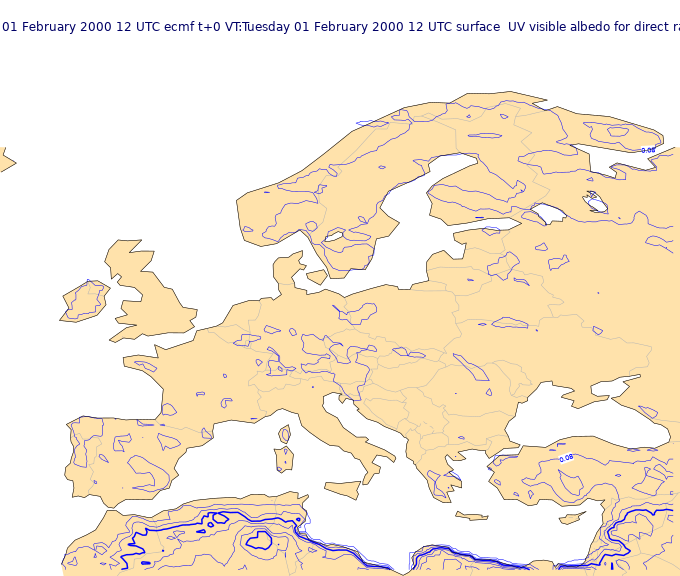

In [ ]:
for s in source_land:
    cml.plot_map(s, title=True)
    break

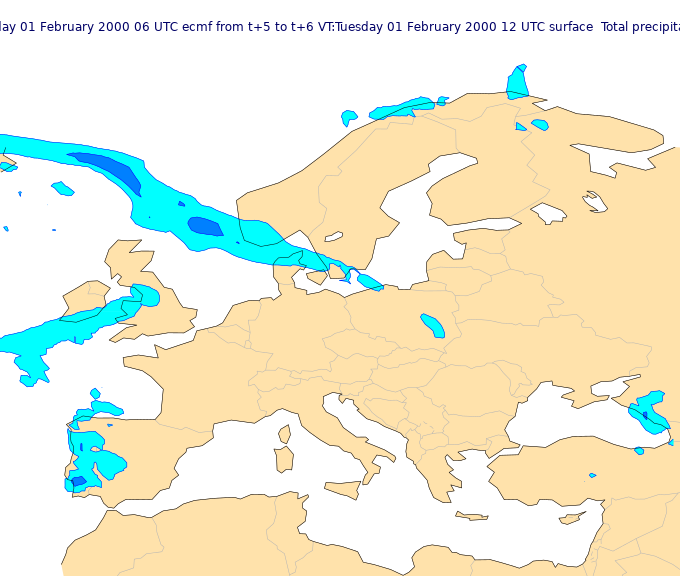

In [ ]:
for s in source_tp:
  cml.plot_map(s, title=True)
  break

In [ ]:
data_ml = source_ml.to_xarray()
df = data_ml.to_dataframe()
df.reset_index(inplace=True)
df.head()

ecCodes provides no latitudes/longitudes for gridType='sh'
ecCodes provides no latitudes/longitudes for gridType='sh'
ecCodes provides no latitudes/longitudes for gridType='sh'


,hybrid,step,time,values,valid_time,t,u,v
0,137.0,0 days,2000-02-01 12:00:00,0,2000-02-01 12:00:00,285.782898,-0.493238,-0.310090
1,137.0,0 days,2000-02-01 12:00:00,1,2000-02-01 12:00:00,0.000000,0.000000,0.000000
2,137.0,0 days,2000-02-01 12:00:00,2,2000-02-01 12:00:00,-4.112029,-0.137239,-0.187205
3,137.0,0 days,2000-02-01 12:00:00,3,2000-02-01 12:00:00,0.000000,0.000000,0.000000
4,137.0,0 days,2000-02-01 12:00:00,4,2000-02-01 12:00:00,-13.999807,1.601304,0.394113


In [ ]:
data_ml = source_tp.to_xarray()
df = data_ml.to_dataframe()
df.reset_index(inplace=True)
df.head()

,number,step,surface,time,values,latitude,longitude,valid_time,tp
0,0,0 days 06:00:00,0.0,2000-02-01 06:00:00,0,74.894549,345.0,2000-02-01 12:00:00,0.000002
1,0,0 days 06:00:00,0.0,2000-02-01 06:00:00,1,74.894549,346.0,2000-02-01 12:00:00,0.000004
2,0,0 days 06:00:00,0.0,2000-02-01 06:00:00,2,74.894549,347.0,2000-02-01 12:00:00,0.000015
3,0,0 days 06:00:00,0.0,2000-02-01 06:00:00,3,74.894549,348.0,2000-02-01 12:00:00,0.000031
4,0,0 days 06:00:00,0.0,2000-02-01 06:00:00,4,74.894549,349.0,2000-02-01 12:00:00,0.000045


In [ ]:
data = source.to_xarray()
df = data.to_dataframe()
df.reset_index(inplace=True)
df.head()

skipping variable: paramId==36 shortName='istl2'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/cfgrib/dataset.py", line 653, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.7/dist-packages/cfgrib/dataset.py", line 586, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=('depthBelowLandLayer',), data=array([0.])) new_value=Variable(dimensions=('depthBelowLandLayer',), data=array([7.]))


,depthBelowLandLayer,number,step,surface,time,values,latitude,longitude,valid_time,aluvp,aluvd,alnip,alnid,cl,cvl,cvh,istl1,slt,sdfor,z,sp,sd,sdor,isor,anor,slor,lsm,fal
0,0.0,0,0 days,0.0,2000-02-01 12:00:00,0,74.894549,345.0,2000-02-01 12:00:00,0.059996,0.06001,0.059994,0.059995,0.0,0.0,0.0,248.446182,0.0,0.0,-36.164307,101068.875,0.0,0.0,0.0,0.785398,0.0001,0.0,0.695766
1,0.0,0,0 days,0.0,2000-02-01 12:00:00,1,74.894549,346.0,2000-02-01 12:00:00,0.059996,0.06001,0.059994,0.059995,0.0,0.0,0.0,249.541885,0.0,0.0,19.132568,100912.875,0.0,0.0,0.0,0.785398,0.0001,0.0,0.674633
2,0.0,0,0 days,0.0,2000-02-01 12:00:00,2,74.894549,347.0,2000-02-01 12:00:00,0.059996,0.06001,0.059994,0.059995,0.0,0.0,0.0,250.449112,0.0,0.0,-3.316650,100861.875,0.0,0.0,0.0,0.785398,0.0001,0.0,0.638973
3,0.0,0,0 days,0.0,2000-02-01 12:00:00,3,74.894549,348.0,2000-02-01 12:00:00,0.059996,0.06001,0.059994,0.059995,0.0,0.0,0.0,251.695206,0.0,0.0,9.390381,100755.875,0.0,0.0,0.0,0.785398,0.0001,0.0,0.548901
4,0.0,0,0 days,0.0,2000-02-01 12:00:00,4,74.894549,349.0,2000-02-01 12:00:00,0.059996,0.06001,0.059994,0.059995,0.0,0.0,0.0,253.098526,0.0,0.0,3.894287,100668.875,0.0,0.0,0.0,0.785398,0.0001,0.0,0.435589


In [ ]:
temp = df.loc[df.latitude - 48.67 < 1]
temp = temp.loc[temp.latitude - 48.67 > 0]

temp = temp.loc[temp['longitude']- 366.5 < 1]
temp = temp.loc[temp.longitude - 366.5 > 0]

In [ ]:
temp.head()

,number,step,surface,time,values,latitude,longitude,valid_time,cvl,cvh,sst,lai_lv,lai_hv,sp,isor,anor,u10,v10,t2m,d2m,lcc,skt,tsn,fal,fsr,flsr
9022,0,0 days,0.0,2000-02-01 12:00:00,9022,49.601853,366.666667,2000-02-01 12:00:00,0.687636,0.307251,NaN,1.796875,1.960938,97831.875,0.410243,-0.554925,2.282547,3.888092,280.084045,277.654022,1.0,280.625427,272.917389,0.116634,0.455623,-5.573890
9023,0,0 days,0.0,2000-02-01 12:00:00,9023,49.601853,367.083333,2000-02-01 12:00:00,0.195480,0.754730,NaN,2.710938,1.398438,97069.875,0.331331,-0.778183,2.662430,3.297272,279.472717,277.386444,1.0,279.795349,272.913483,0.116650,0.790115,-4.988685
9161,0,0 days,0.0,2000-02-01 12:00:00,9161,49.320823,366.666667,2000-02-01 12:00:00,0.419901,0.580099,NaN,2.304688,1.539062,98863.875,0.571292,-0.093155,1.634109,2.896881,280.877014,278.788788,1.0,281.791443,272.792389,0.129665,0.671625,-5.222083
9162,0,0 days,0.0,2000-02-01 12:00:00,9162,49.320823,367.083333,2000-02-01 12:00:00,0.271009,0.728991,NaN,2.560059,1.308716,98753.875,0.816573,-0.578106,2.223953,2.776764,280.855530,278.558319,1.0,281.846130,272.886139,0.120754,0.787120,-5.034583
9300,0,0 days,0.0,2000-02-01 12:00:00,9300,49.039793,366.666667,2000-02-01 12:00:00,0.789029,0.168610,NaN,1.671265,2.217773,99208.875,0.503830,0.199735,1.577469,3.047272,281.414124,279.626678,1.0,282.746521,272.778717,0.146465,0.332026,-5.935706


In [ ]:
temp.longitude.unique()

array([366.66666667, 367.08333333, 366.8       , 367.2       ])

In [ ]:
temp.latitude.unique()

array([49.60185302, 49.32082278, 49.03979254, 48.75876229])

# ftp

In [ ]:
import ftplib

In [ ]:
ftp_server = # ftp server address

my_userid  =  # ftp user id 
my_passwd  =  # ftp password

In [ ]:
# Write a function that initiates a FTP session

def open_ftp_session(ftp_server, my_userid, my_passwd):
    """
       Open a ftp session given the server ftp address,
       the user's ID and the user's password.
       
       @param ftp_server: name of the ftp server (string)
       @param my_userid:  user ID on the ftp server (string)
       @param my_passwd:  user password on the ftp server (string)
    """
    
    ftp_session = ftplib.FTP(ftp_server)
    ftp_session.login(my_userid, my_passwd)
    
    return ftp_session

In [ ]:
ftp_session = open_ftp_session(ftp_server, my_userid, my_passwd)

In [ ]:
ftp_session.retrlines('LIST')

drwxrwxr-x    6 20171      ftpgroup           13 Jul 30 06:03 .
drwxrwxr-x    6 20171      ftpgroup           13 Jul 30 06:03 ..
-rw-------    1 20171      ftpgroup          337 Jul 30 06:03 .banner
-rw-------    1 20171      ftpgroup           19 Jul 30 08:34 .ftpquota
drwxr-xr-x    2 20171      ftpgroup           57 Jul 30 08:34 AI4Land
drwxr-xr-x    9 20171      ftpgroup            9 Jun 24 08:28 GPSRO
drwxr-xr-x    4 20171      ftpgroup            4 Nov 17  2020 data_EPFL
-rwxr-xr-x    1 20171      ftpgroup          18790092000 Dec 18  2020 fc_en_Z500_G.grib
-rwxr-xr-x    1 20171      ftpgroup   7268725880 Dec 18  2020 fc_en_t850_G.grib
-rwxr-xr-x    1 20171      ftpgroup       648372 Jul 28 13:39 plot_evaluation_20200127.png
-rwxr-xr-x    1 20171      ftpgroup       649512 Jul 28 13:27 plot_evaluation_20200510.png
-rwxr-xr-x    1 20171      ftpgroup       647051 Jul 28 13:32 plot_evaluation_20200913.png
drwxr-xr-x   14 20171      ftpgroup           14 Jun  1  2020 radiation_traini

'226-Options: -a -l \n226 13 matches total'

In [ ]:
def ftp_dir_content(ftp_session, dir_name=None):
    """
       List the content of a diirectory in a ftp server.
       If the directory is not provided, will list the content
       of the top directory.
       
       @param ftp_session: ftp session object
       @param dir_name:    name of the directory you want to access (string)
        
       Returned Value:
          - List of directories and files 
           (similar to the Unix command 'ls -l')
    """ 
 
    data = []
    
    if dir_name != None:
        # Change directory
        ftp_session.cwd(dir_name)

    # Get the list of files
    ftp_session.dir(data.append)

    return data

In [ ]:
data = ftp_dir_content(ftp_session, dir_name="/AI4Land/")
for line in data:
    print("-", line)

ftp_session.quit()

- drwxr-xr-x    2 20171      ftpgroup           57 Jul 30 08:34 .
- drwxrwxr-x    6 20171      ftpgroup           13 Jul 30 06:03 ..
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2000.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2001.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2002.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2003.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2004.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2005.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2006.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2007.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2008.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158720 Jul 26 12:15 Aug_rad_2009.grib
- -rwxr-xr-x    1 20171      ftpgroup     31158

'221-Goodbye. You uploaded 0 and downloaded 0 kbytes.\n221 Logout.'

In [ ]:
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
         '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

fnames = []
fnames_ml = []
fnames_tp = []
fnames_2 = []

for y in years:
  # fnames.append("Feb_"+y+".grib")
  # fnames_ml.append("Feb_ml_"+y+".grib")
  # fnames_tp.append("Feb_tp_"+y+".grib")
  fnames.append("Feb_rad_"+y+".grib")
  # fnames_ml.append("Aug_ml_"+y+".grib")
  # fnames_tp.append("Aug_tp_"+y+".grib")

In [ ]:
print(fnames)
print(fnames_ml)
print(fnames_tp)
# print(fnames_2)

['Feb_rad_2000.grib', 'Feb_rad_2001.grib', 'Feb_rad_2002.grib', 'Feb_rad_2003.grib', 'Feb_rad_2004.grib', 'Feb_rad_2005.grib', 'Feb_rad_2006.grib', 'Feb_rad_2007.grib', 'Feb_rad_2008.grib', 'Feb_rad_2009.grib', 'Feb_rad_2010.grib', 'Feb_rad_2011.grib', 'Feb_rad_2012.grib', 'Feb_rad_2013.grib', 'Feb_rad_2014.grib', 'Feb_rad_2015.grib', 'Feb_rad_2016.grib', 'Feb_rad_2017.grib', 'Feb_rad_2018.grib', 'Feb_rad_2019.grib', 'Feb_rad_2020.grib', 'Feb_rad_2021.grib']
[]
[]


In [ ]:
import sys
 
def ftp_get_file(ftp_session, file_name):
    """
         Get a file from a ftp server

         @param ftp_session: ftp session object
         @param file_name: name of the file you want to download  
    """
    try:
        ftp_session.retrbinary("RETR " + file_name ,open(file_name, 'wb').write)
    except:
        print("Error - Cannot obtain file: "+ file_name)

In [ ]:
dir_name  = '/AI4Land/'

ftp_session = open_ftp_session(ftp_server, my_userid, my_passwd)
ftp_session.cwd(dir_name) 

'250 OK. Current directory is /AI4Land'

In [ ]:
# !mkdir ./drive/MyDrive/ESOWC/aug/
# !mkdir ./drive/MyDrive/ESOWC/aug/land/
# !mkdir ./drive/MyDrive/ESOWC/aug/ml/
# !mkdir ./drive/MyDrive/ESOWC/aug/tp/
!mkdir ./drive/MyDrive/ESOWC/feb/rad/

mkdir: cannot create directory ‘./drive/MyDrive/ESOWC/feb/rad/’: File exists


In [ ]:
for f in fnames: 
  print(f)
  ftp_get_file(ftp_session, f)

Feb_rad_2000.grib
Feb_rad_2001.grib
Feb_rad_2002.grib
Feb_rad_2003.grib
Feb_rad_2004.grib
Feb_rad_2005.grib
Feb_rad_2006.grib
Feb_rad_2007.grib
Feb_rad_2008.grib
Feb_rad_2009.grib
Feb_rad_2010.grib
Feb_rad_2011.grib
Feb_rad_2012.grib
Feb_rad_2013.grib
Feb_rad_2014.grib
Feb_rad_2015.grib
Feb_rad_2016.grib
Feb_rad_2017.grib
Feb_rad_2018.grib
Feb_rad_2019.grib
Feb_rad_2020.grib
Feb_rad_2021.grib


In [ ]:
for f in fnames_ml: 
  print(f)
  ftp_get_file(ftp_session, f)

Aug_ml_2000.grib
Aug_ml_2001.grib
Aug_ml_2002.grib
Aug_ml_2003.grib
Aug_ml_2004.grib
Aug_ml_2005.grib
Aug_ml_2006.grib
Aug_ml_2007.grib
Aug_ml_2008.grib
Aug_ml_2009.grib
Aug_ml_2010.grib
Aug_ml_2011.grib
Aug_ml_2012.grib
Aug_ml_2013.grib
Aug_ml_2014.grib
Aug_ml_2015.grib
Aug_ml_2016.grib
Aug_ml_2017.grib
Aug_ml_2018.grib
Aug_ml_2019.grib
Aug_ml_2020.grib
Aug_ml_2021.grib
Error - Cannot obtain file: Aug_ml_2021.grib


In [ ]:
for f in fnames_tp: 
  print(f)
  ftp_get_file(ftp_session, f)

Aug_tp_2000.grib
Aug_tp_2001.grib
Aug_tp_2002.grib
Aug_tp_2003.grib
Aug_tp_2004.grib
Aug_tp_2005.grib
Aug_tp_2006.grib
Aug_tp_2007.grib
Aug_tp_2008.grib
Aug_tp_2009.grib
Aug_tp_2010.grib
Aug_tp_2011.grib
Aug_tp_2012.grib
Aug_tp_2013.grib
Aug_tp_2014.grib
Aug_tp_2015.grib
Aug_tp_2016.grib
Aug_tp_2017.grib
Aug_tp_2018.grib
Aug_tp_2019.grib
Aug_tp_2020.grib
Aug_tp_2021.grib
Error - Cannot obtain file: Aug_tp_2021.grib


In [ ]:
!cp Feb_rad_2000.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2001.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2002.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2003.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2004.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2005.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2006.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2007.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2008.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2009.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2010.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2011.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2012.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2013.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2014.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2015.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2016.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2017.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2018.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2019.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2020.grib  /content/drive/MyDrive/ESOWC/feb/rad/
# !cp Feb_rad_2021.grib  /content/drive/MyDrive/ESOWC/feb/rad/

In [ ]:
!cp Aug_ml_2000.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2001.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2002.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2003.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2004.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2005.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2006.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2007.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2008.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2009.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2010.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2011.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2012.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2013.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2014.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2015.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2016.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2017.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2018.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2019.grib /content/drive/MyDrive/ESOWC/aug/ml/
!cp Aug_ml_2020.grib /content/drive/MyDrive/ESOWC/aug/ml/
# !cp Aug_ml_2021.grib /content/drive/MyDrive/ESOWC/aug/ml/

In [ ]:
!cp Aug_tp_2000.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2001.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2002.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2003.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2004.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2005.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2006.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2007.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2008.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2009.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2010.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2011.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2012.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2013.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2014.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2015.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2016.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2017.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2018.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2019.grib /content/drive/MyDrive/ESOWC/aug/tp/
!cp Aug_tp_2020.grib /content/drive/MyDrive/ESOWC/aug/tp/
# !cp Aug_tp_2021.grib /content/drive/MyDrive/ESOWC/aug/tp/

# Saving data in csv

In [ ]:
!mkdir ./drive/MyDrive/ESOWC/aug/csvs

In [ ]:
# years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
#          '2014', '2015', '2016', '2017', '2018', '2019', '2020']
years = ['2021']

fnames = []
fnames_ml = []
fnames_tp = []
fnames_rad = []

for y in years:
  fnames.append("/content/drive/MyDrive/ESOWC/feb/land/Feb_"+y+".grib")
  fnames_ml.append("/content/drive/MyDrive/ESOWC/feb/ml/Feb_ml_"+y+".grib")
  fnames_tp.append("/content/drive/MyDrive/ESOWC/feb/tp/Feb_tp_"+y+".grib")
  fnames_rad.append("/content/drive/MyDrive/ESOWC/feb/rad/Feb_rad_"+y+".grib")

In [ ]:
def get_df(grbfile_land, grbfile_ml, grbfile_tp, grbfile_rad):
  source_land =  cml.load_source("file", grbfile_land)
  source_ml = cml.load_source("file", grbfile_ml)
  source_tp = cml.load_source("file", grbfile_tp)
  source_rad = cml.load_source("file", grbfile_rad)

  data_land = source_land.to_xarray()
  df_land = data_land.to_dataframe()
  df_land.reset_index(inplace=True)

  data_ml = source_ml.to_xarray()
  df_ml = data_ml.to_dataframe()
  df_ml.reset_index(inplace=True)

  data_tp = source_tp.to_xarray()
  df_tp = data_tp.to_dataframe()
  df_tp.reset_index(inplace=True)

  data_rad = source_rad.to_xarray()
  df_rad = data_rad.to_dataframe()
  df_rad.reset_index(inplace=True)

  new_df = pd.merge(df_ml, df_land,  on = ['latitude', 'longitude', 'valid_time'])
  new_df = pd.merge(df_tp, new_df, on = ['latitude', 'longitude', 'valid_time'])
  new_df = pd.merge(df_rad, new_df, on = ['latitude', 'longitude', 'valid_time'])

  print(new_df.columns)

  # new_df = new_df.drop(columns=['number_x', 'step', 'surface_x', 'time',
  #                               'hybrid', 'step_x', 'time_x', 'depthBelowLandLayer', 
  #                               'number_y', 'step_y', 'surface_y', 'time_y'])
  
  new_df = new_df.drop(columns=['number', 'step_x', 'surface', 'time_x','number_x', 'step_y', 'surface_x',
       'time_y', 'step_x', 'time_x', 'number_y', 'step_y', 'surface_y', 'time_y'])

  return new_df

In [ ]:
for (grbfile_land, grbfile_ml, grbfile_tp, grbfile_rad) in zip(fnames, fnames_ml, fnames_tp, fnames_rad):
  df = get_df(grbfile_land, grbfile_ml, grbfile_tp, grbfile_rad)
  print(grbfile_land[-9:-4])
  df.to_csv("/content/drive/MyDrive/ESOWC/feb/csvs/"+grbfile_land[38:-4]+"csv", index=False)

skipping variable: paramId==36 shortName='istl2'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/cfgrib/dataset.py", line 653, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.7/dist-packages/cfgrib/dataset.py", line 586, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=('depthBelowLandLayer',), data=array([0.])) new_value=Variable(dimensions=('depthBelowLandLayer',), data=array([7.]))


Index(['latitude', 'longitude', 'number', 'step_x', 'surface', 'time_x',
       'valid_time', 'ssrd', 'strd', 'number_x', 'step_y', 'surface_x',
       'time_y', 'tp', 'hybrid', 'step_x', 'time_x', 't', 'u', 'v',
       'depthBelowLandLayer', 'number_y', 'step_y', 'surface_y', 'time_y',
       'aluvp', 'aluvd', 'alnip', 'alnid', 'cl', 'cvl', 'cvh', 'istl1', 'slt',
       'sdfor', 'z', 'sp', 'sd', 'sdor', 'isor', 'anor', 'slor', 't2m', 'd2m',
       'lsm', 'fal'],
      dtype='object')
2021.


In [ ]:
grbfile_land = "/content/drive/MyDrive/ESOWC/aug/land/Aug_2000.grib"
grbfile_ml = "/content/drive/MyDrive/ESOWC/aug/ml/Aug_ml_2000.grib"
grbfile_tp = "/content/drive/MyDrive/ESOWC/aug/tp/Aug_tp_2000.grib"
grbfile_rad= "/content/drive/MyDrive/ESOWC/aug/rad/Aug_rad_2000.grib"

In [ ]:
source_land =  cml.load_source("file", grbfile_land)
source_ml = cml.load_source("file", grbfile_ml)
source_tp = cml.load_source("file", grbfile_tp)
source_rad = cml.load_source("file", grbfile_rad)

In [ ]:
data_ml = source_ml.to_xarray()
df_ml = data_ml.to_dataframe()
df_ml.reset_index(inplace=True)
df_ml.head()

,hybrid,latitude,longitude,step,time,valid_time,t,u,v
0,137.0,75.0,-15.0,0 days,2000-08-01 12:00:00,2000-08-01 12:00:00,274.153931,-2.740979,1.150603
1,137.0,75.0,-15.0,0 days,2000-08-01 13:00:00,2000-08-01 13:00:00,274.185730,-2.615326,1.457206
2,137.0,75.0,-15.0,0 days,2000-08-01 14:00:00,2000-08-01 14:00:00,274.237976,-2.198679,1.605548
3,137.0,75.0,-15.0,0 days,2000-08-01 15:00:00,2000-08-01 15:00:00,274.320587,-1.981892,1.256331
4,137.0,75.0,-15.0,0 days,2000-08-01 16:00:00,2000-08-01 16:00:00,274.182251,-2.286677,0.738268


In [ ]:
data_land = source_land.to_xarray()
df_land = data_land.to_dataframe()
df_land.reset_index(inplace=True)
df_land.head()

skipping variable: paramId==36 shortName='istl2'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/cfgrib/dataset.py", line 653, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.7/dist-packages/cfgrib/dataset.py", line 586, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=('depthBelowLandLayer',), data=array([0.])) new_value=Variable(dimensions=('depthBelowLandLayer',), data=array([7.]))


,depthBelowLandLayer,latitude,longitude,number,step,surface,time,valid_time,aluvp,aluvd,alnip,alnid,cl,cvl,cvh,istl1,slt,sdfor,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal
0,0.0,75.0,-15.0,0,0 days,0.0,2000-08-01 12:00:00,2000-08-01 12:00:00,0.060007,0.060001,0.059992,0.060004,0.0,0.0,0.0,273.159790,0.0,0.0,-20.019043,100986.7500,0.0,0.0,0.0,0.785398,0.0001,273.101318,272.067383,0.0,0.253459
1,0.0,75.0,-15.0,0,0 days,0.0,2000-08-01 13:00:00,2000-08-01 13:00:00,0.060008,0.060002,0.060005,0.060002,0.0,0.0,0.0,273.160278,0.0,0.0,-20.019043,100956.2500,0.0,0.0,0.0,0.785398,0.0001,273.068848,272.335693,0.0,0.253459
2,0.0,75.0,-15.0,0,0 days,0.0,2000-08-01 14:00:00,2000-08-01 14:00:00,0.060008,0.060003,0.060002,0.060000,0.0,0.0,0.0,273.159790,0.0,0.0,-20.019043,100935.5000,0.0,0.0,0.0,0.785398,0.0001,273.194092,272.341553,0.0,0.253459
3,0.0,75.0,-15.0,0,0 days,0.0,2000-08-01 15:00:00,2000-08-01 15:00:00,0.060009,0.060004,0.060000,0.059998,0.0,0.0,0.0,273.159546,0.0,0.0,-20.019043,100887.0000,0.0,0.0,0.0,0.785398,0.0001,273.135254,272.447998,0.0,0.253459
4,0.0,75.0,-15.0,0,0 days,0.0,2000-08-01 16:00:00,2000-08-01 16:00:00,0.060009,0.060005,0.059998,0.059995,0.0,0.0,0.0,273.159637,0.0,0.0,-20.019043,100779.6875,0.0,0.0,0.0,0.785398,0.0001,273.132812,272.543701,0.0,0.253459


In [ ]:
data_tp = source_tp.to_xarray()
df_tp = data_tp.to_dataframe()
df_tp.reset_index(inplace=True)
df_tp.head()

,latitude,longitude,number,step,surface,time,valid_time,tp
0,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-01 06:00:00,2000-08-01 12:00:00,1.072884e-05
1,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-02 06:00:00,2000-08-02 12:00:00,4.768372e-07
2,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-03 06:00:00,2000-08-03 12:00:00,2.622604e-06
3,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-04 06:00:00,2000-08-04 12:00:00,9.536743e-07
4,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-05 06:00:00,2000-08-05 12:00:00,1.025200e-05


In [ ]:
data_rad = source_rad.to_xarray()
df_rad = data_rad.to_dataframe()
df_rad.reset_index(inplace=True)
df_rad.head()

,latitude,longitude,number,step,surface,time,valid_time,ssrd,strd
0,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-01 06:00:00,2000-08-01 12:00:00,1036569.375,1105346.875
1,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-02 06:00:00,2000-08-02 12:00:00,788313.625,1130970.000
2,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-03 06:00:00,2000-08-03 12:00:00,1003801.125,1102078.750
3,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-04 06:00:00,2000-08-04 12:00:00,1191779.750,1039896.250
4,75.0,-15.0,0,0 days 06:00:00,0.0,2000-08-05 06:00:00,2000-08-05 12:00:00,764763.500,1097400.000


In [ ]:
new_df = pd.merge(df_ml, df_land,  on = ['latitude', 'longitude', 'valid_time'])
new_df = pd.merge(df_tp, new_df, on = ['latitude', 'longitude', 'valid_time'])
new_df = pd.merge(df_rad, new_df, on = ['latitude', 'longitude', 'valid_time'])

new_df.columns

Index(['latitude', 'longitude', 'number', 'step_x', 'surface', 'time_x',
       'valid_time', 'ssrd', 'strd', 'number_x', 'step_y', 'surface_x',
       'time_y', 'tp', 'hybrid', 'step_x', 'time_x', 't', 'u', 'v',
       'depthBelowLandLayer', 'number_y', 'step_y', 'surface_y', 'time_y',
       'aluvp', 'aluvd', 'alnip', 'alnid', 'cl', 'cvl', 'cvh', 'istl1', 'slt',
       'sdfor', 'z', 'sp', 'sd', 'sdor', 'isor', 'anor', 'slor', 't2m', 'd2m',
       'lsm', 'fal'],
      dtype='object')

In [ ]:
new_df = new_df.drop(columns=['number', 'step_x', 'surface', 'time_x','number_x', 'step_y', 'surface_x',
       'time_y', 'step_x', 'time_x', 'number_y', 'step_y', 'surface_y', 'time_y'])

In [ ]:
new_df.head()

,latitude,longitude,number_x,step,surface_x,time,valid_time,tp,hybrid,step_x,time_x,t,u,v,depthBelowLandLayer,number_y,step_y,surface_y,time_y,aluvp,aluvd,alnip,alnid,cl,cvl,cvh,istl1,slt,sdfor,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal
0,75.0,-15.0,0,0 days 06:00:00,0.0,2000-02-01 06:00:00,2000-02-01 12:00:00,2.145767e-06,137.0,0 days,2000-02-01 12:00:00,247.181488,2.842760,-8.513624,0.0,0,0 days,0.0,2000-02-01 12:00:00,0.059999,0.060013,0.059994,0.059995,0.0,0.0,0.0,248.368118,0.0,0.0,-20.019043,101049.8750,0.0,0.0,0.0,0.785398,0.0001,249.285889,246.611938,0.0,0.697397
1,75.0,-15.0,0,0 days 06:00:00,0.0,2000-02-02 06:00:00,2000-02-02 12:00:00,2.264977e-06,137.0,0 days,2000-02-02 12:00:00,249.033340,3.646779,-2.670753,0.0,0,0 days,0.0,2000-02-02 12:00:00,0.059992,0.060010,0.059994,0.059995,0.0,0.0,0.0,248.131775,0.0,0.0,-20.019043,101024.5625,0.0,0.0,0.0,0.785398,0.0001,248.942917,246.283829,0.0,0.704150
2,75.0,-15.0,0,0 days 06:00:00,0.0,2000-02-03 06:00:00,2000-02-03 12:00:00,3.576279e-06,137.0,0 days,2000-02-03 12:00:00,249.738785,4.094452,-1.716292,0.0,0,0 days,0.0,2000-02-03 12:00:00,0.059995,0.059999,0.059994,0.059995,0.0,0.0,0.0,247.823410,0.0,0.0,-20.019043,99424.6250,0.0,0.0,0.0,0.785398,0.0001,248.832672,246.314407,0.0,0.709857
3,75.0,-15.0,0,0 days 06:00:00,0.0,2000-02-04 06:00:00,2000-02-04 12:00:00,9.536743e-07,137.0,0 days,2000-02-04 12:00:00,252.083954,0.872898,-4.212234,0.0,0,0 days,0.0,2000-02-04 12:00:00,0.059997,0.060004,0.059994,0.059995,0.0,0.0,0.0,249.671341,0.0,0.0,-20.019043,100198.5000,0.0,0.0,0.0,0.785398,0.0001,251.375275,249.135376,0.0,0.716862
4,75.0,-15.0,0,0 days 06:00:00,0.0,2000-02-05 06:00:00,2000-02-05 12:00:00,8.118153e-05,137.0,0 days,2000-02-05 12:00:00,255.007767,0.305676,-4.120874,0.0,0,0 days,0.0,2000-02-05 12:00:00,0.059991,0.060009,0.059994,0.059995,0.0,0.0,0.0,251.806305,0.0,0.0,-20.019043,99304.6875,0.0,0.0,0.0,0.785398,0.0001,254.457886,252.465515,0.0,0.709720


In [ ]:
temp = df_land.loc[df_land.latitude - 48.67 < 1]
temp = temp.loc[temp.latitude - 48.67 > 0]

temp = temp.loc[temp.longitude- 7.07 < 1]
temp = temp.loc[temp.longitude - 7.07 > 0]

In [ ]:
temp.head()

,depthBelowLandLayer,latitude,longitude,number,step,surface,time,valid_time,aluvp,aluvd,alnip,alnid,cl,cvl,cvh,istl1,slt,sdfor,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal
4115274,0.0,49.5,7.25,0,0 days,0.0,2000-02-01 12:00:00,2000-02-01 12:00:00,0.043603,0.045952,0.174923,0.190946,0.000759,0.19548,0.75473,271.459900,2.0,43.768555,3490.23291,97905.8750,0.0,53.848816,0.537178,-0.694265,0.010106,280.195068,277.737915,0.999241,0.124216
4115275,0.0,49.5,7.25,0,0 days,0.0,2000-02-01 13:00:00,2000-02-01 13:00:00,0.043613,0.045957,0.174938,0.190946,0.000759,0.19548,0.75473,271.459595,2.0,43.768555,3490.23291,97794.0625,0.0,53.848816,0.537178,-0.694265,0.010106,280.767578,278.123962,0.999241,0.124216
4115276,0.0,49.5,7.25,0,0 days,0.0,2000-02-01 14:00:00,2000-02-01 14:00:00,0.043623,0.045971,0.174938,0.190946,0.000759,0.19548,0.75473,271.460632,2.0,43.768555,3490.23291,97712.8750,0.0,53.848816,0.537178,-0.694265,0.010106,281.229065,278.442871,0.999241,0.124216
4115277,0.0,49.5,7.25,0,0 days,0.0,2000-02-01 15:00:00,2000-02-01 15:00:00,0.043641,0.045976,0.174938,0.190946,0.000759,0.19548,0.75473,271.460205,2.0,43.768555,3490.23291,97673.1250,0.0,53.848816,0.537178,-0.694265,0.010106,281.302917,278.447388,0.999241,0.124216
4115278,0.0,49.5,7.25,0,0 days,0.0,2000-02-01 16:00:00,2000-02-01 16:00:00,0.043651,0.045989,0.174938,0.190931,0.000759,0.19548,0.75473,271.459778,2.0,43.768555,3490.23291,97603.0000,0.0,53.848816,0.537178,-0.694265,0.010106,281.120483,278.874939,0.999241,0.124216


# Analyzing data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import climetlab as cml

In [ ]:
# point_dict = {
#     'London, UK': [0., 51.75],
#     'Hesse, France': [7.25, 48.75],
#     'Espirra, Portugal': [-8.60, 38.64],
#     'Loobos, Netherlands': [5.74, 52.17],
#     'Bugac, Hungary': [19.60, 46.69],
#     'Falkenberg, Germany': [14.12, 52.17],
#     'Cabauw, Netherlands': [4.93, 51.97],
#     'Heraklion, Greece': [25.13, 35.33],
#     'Toulouse, France': [1.45, 43.60],
#     'Amsterdam, Netherlands': [4.89, 52.37],
# }  

point_dict = {
    'London, UK': [0., 51.75],
    'Hesse, France': [7.25, 48.75],
    'Espirra, Portugal': [-8.50, 38.75],
    'Loobos, Netherlands': [5.75, 52.25],
    'Bugac, Hungary': [19.50, 46.75],
    'Falkenberg, Germany': [14.25, 52.25],
    'Cabauw, Netherlands': [5., 52.],
    'Heraklion, Greece': [25.25, 35.25],
    'Toulouse, France': [1.5, 43.5],
    'Amsterdam, Netherlands': [5.0, 52.5],
}

In [ ]:
def get_data_point(df, point):
  temp = df.loc[df.latitude == point[1]]
  temp = temp.loc[temp.longitude == point[0]]
  return temp

In [ ]:
src_feb = "/content/drive/MyDrive/ESOWC/feb/csvs/"
src_aug = "/content/drive/MyDrive/ESOWC/aug/csvs/"

csv_files_feb = os.listdir(src_feb)
csv_files_aug = os.listdir(src_aug)

In [ ]:
df = pd.read_csv(os.path.join(src_feb, "Feb_2000.csv"))

In [ ]:
# point = [5.0, 52.5]
# temp = df.loc[np.abs(df.latitude - point[1]) < 0.5]
# temp = temp.loc[np.abs(temp.latitude - point[1]) >= 0]

# temp = temp.loc[np.abs(temp.longitude- point[0]) < 0.5]
# temp = temp.loc[np.abs(temp.longitude - point[0]) >= 0]

# print(temp.latitude.unique())
# print(temp.longitude.unique())

# print(df.latitude.min(), df.latitude.max())
# print(df.longitude.min(), df.longitude.max())

df.head()

,latitude,longitude,valid_time,ssrd,strd,tp,hybrid,t,u,v,depthBelowLandLayer,aluvp,aluvd,alnip,alnid,cl,cvl,cvh,istl1,slt,sdfor,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal
0,75.0,-15.0,2000-02-01 12:00:00,0.0,509637.7,2.145767e-06,137.0,247.18149,2.842760,-8.513624,0.0,0.059999,0.060013,0.059994,0.059995,0.0,0.0,0.0,248.36812,0.0,0.0,-20.019043,101049.875,0.0,0.0,0.0,0.785398,0.0001,249.28589,246.61194,0.0,0.697397
1,75.0,-15.0,2000-02-02 12:00:00,0.0,587736.6,2.264976e-06,137.0,249.03334,3.646779,-2.670753,0.0,0.059992,0.060010,0.059994,0.059995,0.0,0.0,0.0,248.13177,0.0,0.0,-20.019043,101024.560,0.0,0.0,0.0,0.785398,0.0001,248.94292,246.28383,0.0,0.704150
2,75.0,-15.0,2000-02-03 12:00:00,0.0,599212.0,3.576279e-06,137.0,249.73878,4.094452,-1.716292,0.0,0.059995,0.059999,0.059994,0.059995,0.0,0.0,0.0,247.82341,0.0,0.0,-20.019043,99424.625,0.0,0.0,0.0,0.785398,0.0001,248.83267,246.31440,0.0,0.709857
3,75.0,-15.0,2000-02-04 12:00:00,0.0,604780.8,9.536743e-07,137.0,252.08395,0.872898,-4.212233,0.0,0.059997,0.060004,0.059994,0.059995,0.0,0.0,0.0,249.67134,0.0,0.0,-20.019043,100198.500,0.0,0.0,0.0,0.785398,0.0001,251.37527,249.13538,0.0,0.716862
4,75.0,-15.0,2000-02-05 12:00:00,0.0,828090.4,8.118153e-05,137.0,255.00777,0.305675,-4.120874,0.0,0.059991,0.060009,0.059994,0.059995,0.0,0.0,0.0,251.80630,0.0,0.0,-20.019043,99304.690,0.0,0.0,0.0,0.785398,0.0001,254.45789,252.46552,0.0,0.709720


In [ ]:
# df[['date', 'time']] = df.valid_time.split()

# df[['y', 'm', 'd']] = df.date.apply(
#     lambda x: pd.Series(str(x).split('-'))
# )

temp = df.loc[df.valid_time.str.match(r'^2000-02-24')]

In [ ]:
# finding input data for points provided

df_lists = []

for f in csv_files_aug: 
  print(f)
  df = pd.read_csv(os.path.join(src_aug, f))
  for loc in point_dict.keys():
    temp = get_data_point(df, point_dict[loc])
    df_lists.append(temp)
    temp[['date','time']] = temp.valid_time.apply(
      lambda x: pd.Series(str(x).split()))
    temp['city'] = loc
    
result = pd.concat(df_lists, ignore_index=True)

result.to_csv("./drive/MyDrive/ESOWC/aug/places_aug.csv")

df_lists = []

for f in csv_files_feb: 
  print(f)
  df = pd.read_csv(os.path.join(src_feb, f))
  for loc in point_dict.keys():
    temp = get_data_point(df, point_dict[loc])
    df_lists.append(temp)
    temp[['date','time']] = temp.valid_time.apply(
      lambda x: pd.Series(str(x).split()))
    temp['city'] = loc
    
result = pd.concat(df_lists, ignore_index=True)

result.to_csv("./drive/MyDrive/ESOWC/feb/places_feb.csv")

Aug_2000.csv
Aug_2001.csv
Aug_2002.csv
Aug_2003.csv
Aug_2004.csv
Aug_2005.csv
Aug_2006.csv
Aug_2007.csv
Aug_2008.csv
Aug_2009.csv
Aug_2010.csv
Aug_2011.csv
Aug_2012.csv
Aug_2013.csv
Aug_2014.csv
Aug_2015.csv
Aug_2016.csv
Aug_2017.csv
Aug_2018.csv
Aug_2019.csv
Aug_2020.csv
Feb_2021.csv
Feb_2000.csv
Feb_2001.csv
Feb_2002.csv
Feb_2003.csv
Feb_2004.csv
Feb_2005.csv
Feb_2006.csv
Feb_2007.csv
Feb_2008.csv
Feb_2009.csv
Feb_2010.csv
Feb_2011.csv
Feb_2012.csv
Feb_2013.csv
Feb_2014.csv
Feb_2015.csv
Feb_2016.csv
Feb_2017.csv
Feb_2018.csv
Feb_2019.csv
Feb_2020.csv


In [ ]:
result.head()

,latitude,longitude,valid_time,tp,t,u,v,aluvp,aluvd,alnip,alnid,cl,cvl,cvh,istl1,slt,sdfor,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal,date,time,city
0,51.75,0.0,2000-02-01 12:00:00,0.000082,282.56820,5.333971,5.149462,0.046403,0.051560,0.165264,0.186308,0.010333,0.858461,0.095856,271.45990,4.0,15.742401,706.2466,100534.875,0.0,26.754883,0.676308,-0.785447,0.003667,283.04370,279.40490,0.989667,0.123758,2000-02-01,12:00:00,"London, UK"
1,51.75,0.0,2000-02-02 12:00:00,0.000000,280.35460,4.169728,-2.223487,0.046481,0.051633,0.165646,0.186689,0.010333,0.858461,0.095856,271.46040,4.0,15.742401,706.2466,101275.060,0.0,26.754883,0.676308,-0.785447,0.003667,281.13043,275.48303,0.989667,0.123996,2000-02-02,12:00:00,"London, UK"
2,51.75,0.0,2000-02-03 12:00:00,0.000000,280.64990,3.012909,1.640641,0.046575,0.051706,0.166012,0.187070,0.010333,0.858461,0.095856,271.45966,4.0,15.742401,706.2466,102482.125,0.0,26.754883,0.676308,-0.785447,0.003667,280.71060,277.20306,0.989667,0.124240,2000-02-03,12:00:00,"London, UK"
3,51.75,0.0,2000-02-04 12:00:00,0.000000,282.79294,5.572605,3.630052,0.046661,0.051779,0.166379,0.187467,0.010333,0.858461,0.095856,271.46040,4.0,15.742401,706.2466,102216.500,0.0,26.754883,0.676308,-0.785447,0.003667,283.00613,280.41663,0.989667,0.124470,2000-02-04,12:00:00,"London, UK"
4,51.75,0.0,2000-02-05 12:00:00,0.000000,282.16107,2.355480,4.458227,0.046738,0.051846,0.166745,0.187849,0.010333,0.858461,0.095856,271.46010,4.0,15.742401,706.2466,101688.190,0.0,26.754883,0.676308,-0.785447,0.003667,282.63367,278.17548,0.989667,0.124714,2000-02-05,12:00:00,"London, UK"


In [ ]:
result.city.unique()

array(['London, UK', 'Hesse, France', 'Espirra, Portugal',
       'Loobos, Netherlands', 'Bugac, Hungary', 'Falkenberg, Germany',
       'Cabauw, Netherlands', 'Heraklion, Greece', 'Toulouse, France',
       'Amsterdam, Netherlands'], dtype=object)

# Visualizing aggregate variables

## Aggregate rainfall in feb

In [ ]:
df_2019 = result.loc[result.date.str.match(r'^2019')][['latitude', 'longitude',  'date',  'time', 'tp']]
df_2019[['y', 'm', 'd']] = df_2019.date.apply(
    lambda x: pd.Series(str(x).split('-'))
)
tp_feb_2019 = df_2019.groupby(['d'], as_index=False).agg({'latitude': 'max', 'longitude': 'max', 'time' : lambda x: list(x), 'tp': 'sum'})

NameError: ignored

In [ ]:
tp_feb_2019.head()

NameError: ignored

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(tp_feb_2019['d'], tp_feb_2019['tp'])
plt.title("Total Precipitation For Feb 2019")
plt.xlabel("Days")
plt.ylabel("Total Precipitation")

In [ ]:
df = result[['latitude', 'longitude',  'date',  'time', 'tp']]
df[['y', 'm', 'd']] = df.date.apply(lambda x: pd.Series(str(x).split('-')))
tp_feb = df.groupby(['y'], as_index=False).agg({'latitude': 'max', 'longitude': 'max', 'date': lambda x: list(x), 'time' : lambda x: list(x), 'tp': 'sum'})

In [ ]:
tp_feb.head()

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(tp_feb['y'], tp_feb['tp'])
plt.title("Total Precipitation For Feb Over the years")
plt.xlabel("Years")
plt.ylabel("Total Precipitation")

## Aggregate 2m temperature in feb

In [ ]:
df = result[['latitude', 'longitude',  'date',  'time', 't2m']]
df[['y', 'm', 'd']] = df.date.apply(lambda x: pd.Series(str(x).split('-')))
t2m_feb = df.groupby(['y'], as_index=False).agg({'latitude': 'max', 'longitude': 'max', 'date': lambda x: list(x), 'time' : lambda x: list(x), 't2m': 'max'})

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Text(0, 0.5, '2m Temperature (K)')

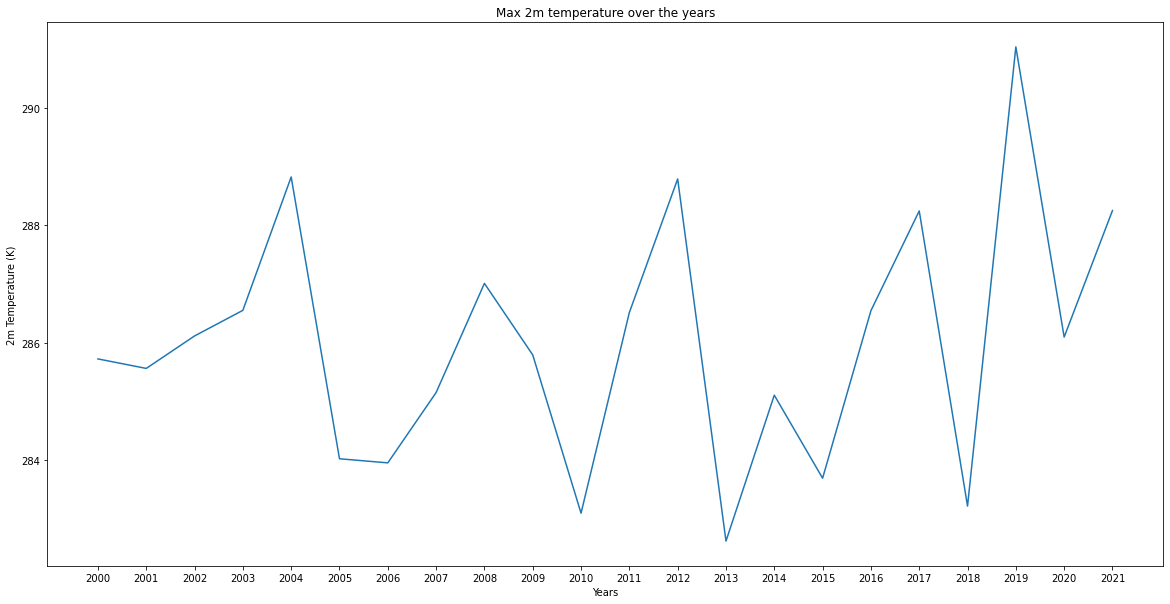

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(t2m_feb['y'], t2m_feb['t2m'])
plt.title("Max 2m temperature over the years")
plt.xlabel("Years")
plt.ylabel("2m Temperature (K)")

# Merging input and ground-truth

In [4]:
result_feb = pd.read_csv("./drive/MyDrive/ESOWC/feb/places_feb.csv")
result_feb = result_feb.drop(columns=['Unnamed: 0'])
result_feb = result_feb.rename(columns={'city': 'Location', 'date': 'datetime'})

result_aug = pd.read_csv("./drive/MyDrive/ESOWC/aug/places_aug.csv")
result_aug = result_aug.drop(columns=['Unnamed: 0'])
result_aug = result_aug.rename(columns={'city': 'Location', 'date': 'datetime'})

result = pd.concat([result_feb, result_aug],  ignore_index=True)
result.head()

,latitude,longitude,valid_time,ssrd,strd,tp,hybrid,t,u,v,depthBelowLandLayer,aluvp,aluvd,alnip,alnid,cl,cvl,cvh,istl1,slt,sdfor,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal,datetime,time,Location
0,51.75,0.0,2021-02-01 12:00:00,486464.0,1150422.4,2.980232e-06,137.0,276.70157,-0.033991,-2.784941,0.0,0.046403,0.051560,0.165264,0.186308,0.010333,0.858461,0.095856,271.46020,4.0,15.742401,706.2466,98938.000,0.000401,26.754883,0.676308,-0.785447,0.003667,276.68805,274.57056,0.989667,0.137461,2021-02-01,12:00:00,"London, UK"
1,51.75,0.0,2021-02-02 12:00:00,481792.0,1224732.1,3.933907e-06,137.0,284.22644,4.176880,3.157758,0.0,0.046481,0.051633,0.165646,0.186689,0.010333,0.858461,0.095856,271.46040,4.0,15.742401,706.2466,98637.310,0.000000,26.754883,0.676308,-0.785447,0.003667,283.51852,281.95117,0.989667,0.126971,2021-02-02,12:00:00,"London, UK"
2,51.75,0.0,2021-02-03 12:00:00,512512.0,1138345.2,5.078316e-05,137.0,281.29550,1.656929,-1.387522,0.0,0.046575,0.051706,0.166012,0.187070,0.010333,0.858461,0.095856,271.45984,4.0,15.742401,706.2466,98503.940,0.000000,26.754883,0.676308,-0.785447,0.003667,281.54900,280.26166,0.989667,0.124240,2021-02-03,12:00:00,"London, UK"
3,51.75,0.0,2021-02-04 12:00:00,796480.0,1075577.8,1.995563e-04,137.0,281.48100,-1.564789,3.998148,0.0,0.046661,0.051779,0.166379,0.187467,0.010333,0.858461,0.095856,271.46045,4.0,15.742401,706.2466,100139.875,0.000000,26.754883,0.676308,-0.785447,0.003667,280.85583,279.55847,0.989667,0.124470,2021-02-04,12:00:00,"London, UK"
4,51.75,0.0,2021-02-05 12:00:00,819648.0,1173505.8,5.960464e-07,137.0,281.07147,1.632652,2.751363,0.0,0.046738,0.051846,0.166745,0.187849,0.010333,0.858461,0.095856,271.45996,4.0,15.742401,706.2466,100084.310,0.000000,26.754883,0.676308,-0.785447,0.003667,281.42807,279.10895,0.989667,0.124714,2021-02-05,12:00:00,"London, UK"


In [5]:
df_gt = pd.read_csv("./drive/MyDrive/ESOWC/LST_super_data.csv")
df_gt = df_gt.drop(columns=['Unnamed: 0'])
df_gt.head()

,Location,time,datetime,Year,Month,Day,DOY,LST_Day_1km_Max,ERA5_skin_temperature,LST_Day_1km_Max_max,LST_Day_1km_Max_mode,LST_Day_1km_Max_mean
0,"Hesse, France",9.513504e+11,2000-02-24,2000,2,24,55,NaN,278.304688,NaN,NaN,NaN
1,"Hesse, France",9.514368e+11,2000-02-25,2000,2,25,56,NaN,280.426285,NaN,NaN,NaN
2,"Hesse, France",9.515232e+11,2000-02-26,2000,2,26,57,NaN,283.963257,282.70,280.720000,281.303963
3,"Hesse, France",9.516096e+11,2000-02-27,2000,2,27,58,286.02,286.891205,287.52,285.570973,285.190293
4,"Hesse, France",9.516960e+11,2000-02-28,2000,2,28,59,287.52,288.209717,288.10,286.570993,286.280478


In [6]:
df_gt.Location.unique()

array(['Hesse, France', 'Espirra, Portugal', 'Loobos, Netherlands',
       'Bugac, Hungary', 'Falkenberg, Germany', 'Cabauw, Netherlands',
       'Heraklion, Greece', 'London, UK', 'Toulouse, France',
       'Amsterdam, Netherlands', 'New Delhi, India', 'Bengaluru, India'],
      dtype=object)

In [7]:
result.Location.unique()

array(['London, UK', 'Hesse, France', 'Espirra, Portugal',
       'Loobos, Netherlands', 'Bugac, Hungary', 'Falkenberg, Germany',
       'Cabauw, Netherlands', 'Heraklion, Greece', 'Toulouse, France',
       'Amsterdam, Netherlands'], dtype=object)

In [8]:
merged_df = pd.merge(result, df_gt, on=['Location', 'datetime'])
merged_df = merged_df.drop(columns=['valid_time', 'time_y', 'hybrid', 'depthBelowLandLayer'])

# merged_df = merged_df.drop(columns=['valid_time','Year', 'Month', 'Day', 'DOY', 'time_y' ])

In [9]:
merged_df.head()

,latitude,longitude,ssrd,strd,tp,t,u,v,aluvp,aluvd,alnip,alnid,cl,cvl,cvh,istl1,slt,sdfor,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal,datetime,time_x,Location,Year,Month,Day,DOY,LST_Day_1km_Max,ERA5_skin_temperature,LST_Day_1km_Max_max,LST_Day_1km_Max_mode,LST_Day_1km_Max_mean
0,51.75,0.0,486464.0,1150422.4,2.980232e-06,276.70157,-0.033991,-2.784941,0.046403,0.051560,0.165264,0.186308,0.010333,0.858461,0.095856,271.46020,4.0,15.742401,706.2466,98938.000,0.000401,26.754883,0.676308,-0.785447,0.003667,276.68805,274.57056,0.989667,0.137461,2021-02-01,12:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN
1,51.75,0.0,485952.0,1136255.5,3.576279e-07,276.83508,0.429789,-2.630139,0.046413,0.051565,0.165295,0.186323,0.010333,0.858461,0.095856,271.45966,4.0,15.742401,706.2466,99017.940,0.000381,26.754883,0.676308,-0.785447,0.003667,276.77435,274.30103,0.989667,0.136835,2021-02-01,13:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN
2,51.75,0.0,561024.0,1085301.6,0.000000e+00,276.86070,0.349520,-2.485342,0.046416,0.051563,0.165310,0.186338,0.010333,0.858461,0.095856,271.46045,4.0,15.742401,706.2466,99062.060,0.000367,26.754883,0.676308,-0.785447,0.003667,276.84113,274.07330,0.989667,0.136316,2021-02-01,14:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN
3,51.75,0.0,416768.0,1120128.5,0.000000e+00,276.92767,0.081392,-2.077607,0.046418,0.051569,0.165325,0.186353,0.010333,0.858461,0.095856,271.45975,4.0,15.742401,706.2466,99133.310,0.000357,26.754883,0.676308,-0.785447,0.003667,276.86200,273.82397,0.989667,0.135889,2021-02-01,15:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN
4,51.75,0.0,261856.0,1092693.5,0.000000e+00,276.94590,0.106323,-1.385651,0.046421,0.051574,0.165341,0.186384,0.010333,0.858461,0.095856,271.45972,4.0,15.742401,706.2466,99210.875,0.000354,26.754883,0.676308,-0.785447,0.003667,276.81050,273.40600,0.989667,0.135645,2021-02-01,16:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN


In [10]:
final_df = merged_df.drop(columns=['latitude', 'longitude', 't',])
final_df = final_df.drop(columns=['sdfor', 'cl', 'aluvp', 'alnip'])


# Some special columns based on the discussions
final_df['albedo'] = 0.45976*final_df.aluvd + 0.54024*final_df.alnid
final_df['wind_speed'] = np.sqrt(final_df.u**2 + final_df.v**2)
final_df['rad'] = final_df.ssrd + final_df.strd

# dropping the columns which are already used for calculations above
final_df = final_df.drop(columns=['u', 'v', 'aluvd', 'alnid', 'ssrd', 'strd'])

final_df.head()

,tp,cvl,cvh,istl1,slt,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal,datetime,time_x,Location,Year,Month,Day,DOY,LST_Day_1km_Max,ERA5_skin_temperature,LST_Day_1km_Max_max,LST_Day_1km_Max_mode,LST_Day_1km_Max_mean,albedo,wind_speed,rad
0,2.980232e-06,0.858461,0.095856,271.46020,4.0,706.2466,98938.000,0.000401,26.754883,0.676308,-0.785447,0.003667,276.68805,274.57056,0.989667,0.137461,2021-02-01,12:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN,0.124356,2.785148,1636886.4
1,3.576279e-07,0.858461,0.095856,271.45966,4.0,706.2466,99017.940,0.000381,26.754883,0.676308,-0.785447,0.003667,276.77435,274.30103,0.989667,0.136835,2021-02-01,13:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN,0.124367,2.665024,1622207.5
2,0.000000e+00,0.858461,0.095856,271.46045,4.0,706.2466,99062.060,0.000367,26.754883,0.676308,-0.785447,0.003667,276.84113,274.07330,0.989667,0.136316,2021-02-01,14:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN,0.124374,2.509799,1646325.6
3,0.000000e+00,0.858461,0.095856,271.45975,4.0,706.2466,99133.310,0.000357,26.754883,0.676308,-0.785447,0.003667,276.86200,273.82397,0.989667,0.135889,2021-02-01,15:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN,0.124385,2.079201,1536896.5
4,0.000000e+00,0.858461,0.095856,271.45972,4.0,706.2466,99210.875,0.000354,26.754883,0.676308,-0.785447,0.003667,276.81050,273.40600,0.989667,0.135645,2021-02-01,16:00:00,"London, UK",2021,2,1,32,NaN,278.447998,NaN,NaN,NaN,0.124404,1.389724,1354549.5


In [11]:
# uncomment to see the correlation plots

# import seaborn as sns
# corr = final_df.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

# # Create correlation matrix
# temp_df = final_df.drop(columns=['ERA5_skin_temperature'])

# corr = temp_df.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.95
# # for c in upper.columns:
# #   print(c)

# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# corr

In [12]:
# aggregating the columns by grouping them first on date and cities
final_df = final_df.groupby(['datetime', 'Location'], as_index=False).agg({'tp': 'sum',                                                                             
                                                                            'cvl': 'max',
                                                                            'cvh': 'max',
                                                                            'istl1': 'max',
                                                                            'slt': 'max',
                                                                            'z': 'max',
                                                                            'sp': 'max',
                                                                            'sd': 'max',
                                                                            'sdor': 'max',
                                                                            'isor': 'max',
                                                                            'anor': 'max',
                                                                            'slor': 'max',
                                                                            't2m': 'max',
                                                                            'd2m': 'max',
                                                                            'lsm': 'max',
                                                                            'fal': 'max',
                                                                            'albedo': 'max',
                                                                            'rad': 'max',
                                                                            'wind_speed': 'max',
                                                                            'time_x' : 'max', 
                                                                            'LST_Day_1km_Max_mean': 'max',
                                                                            'LST_Day_1km_Max_mode': 'max',
                                                                            'ERA5_skin_temperature': 'max',
                                                                            'Year': 'max',
                                                                            'Month': 'max',
                                                                            'Day': 'max',
                                                                            'DOY': 'max'
                                                                           })

In [13]:
final_df.head()

,datetime,Location,tp,cvl,cvh,istl1,slt,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal,albedo,rad,wind_speed,time_x,LST_Day_1km_Max_mean,LST_Day_1km_Max_mode,ERA5_skin_temperature,Year,Month,Day,DOY
0,2000-02-24,"Amsterdam, Netherlands",0.000000,0.745840,0.119293,271.4602,3.0,-18.481934,102196.690,0.000000,2.454651,0.417521,-0.172062,0.000511,280.98670,275.53827,0.825991,0.112277,0.118859,2413525.56,6.903876,17:00:00,NaN,NaN,282.543884,2000,2,24,55
1,2000-02-24,"Bugac, Hungary",0.000054,0.703821,0.296179,271.4602,1.0,993.469240,101723.125,0.000064,5.271973,0.340797,0.036897,0.000786,276.50067,271.34464,0.987635,0.153323,0.150202,2232757.50,2.018375,17:00:00,NaN,NaN,279.808060,2000,2,24,55
2,2000-02-24,"Cabauw, Netherlands",0.000000,0.919090,0.064758,271.4602,3.0,-5.554199,102257.190,0.000000,2.601685,0.630409,0.743268,0.000411,281.77870,274.95135,0.951235,0.137668,0.142020,2362204.16,5.521264,17:00:00,NaN,NaN,282.598572,2000,2,24,55
3,2000-02-24,"Espirra, Portugal",0.000000,0.433064,0.539948,271.4602,1.0,856.137200,101693.625,0.000000,22.107788,0.659839,-0.915545,0.003944,295.88544,281.49954,0.991366,0.154025,0.155025,3593100.20,4.342252,17:00:00,NaN,NaN,297.655441,2000,2,24,55
4,2000-02-24,"Falkenberg, Germany",0.001977,0.130242,0.869758,271.4602,2.0,559.787600,101211.625,0.000000,13.955505,0.473701,0.070932,0.002836,278.80713,277.77753,0.979079,0.139606,0.128207,1871253.50,4.786656,17:00:00,NaN,NaN,277.919388,2000,2,24,55


In [ ]:
# pickle the final dataframe

final_df.to_pickle("./drive/MyDrive/ESOWC/merged_io_df.pkl")

# Training only on London

In [14]:
london_df = final_df.loc[final_df['Location'] == 'London, UK']

In [15]:
train_london_df = london_df.loc[london_df.datetime.str.match(r'^2000|^2001|^2002|^2003|^2004|^2005|^2006|^2007|^2008|^2009|^2010|^2011|^2012|^2013|^2014|^2015|^2016|^2017|^2018')]
test_london_df = london_df.loc[london_df.datetime.str.match(r'^2019|^2020|^2021')]

train_london_df = train_london_df.dropna().reset_index().drop(columns=["index"])

In [16]:
print(len(train_london_df))
print(len(test_london_df))

654
147


In [32]:
y_train = np.array(train_london_df['LST_Day_1km_Max_mean'])
X_train = np.array(train_london_df.drop(columns=["LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature", "Location", "datetime", "time_x", "Year", "Month", "Day", "DOY", "rad"
                                                 ]))
y_test = np.array(test_london_df['LST_Day_1km_Max_mean'])
X_test = np.array(test_london_df.drop(columns=["LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature", "Location", "datetime", "time_x", "Year", "Month", "Day", "DOY", "rad"
                                               ]))

y_train_indices = train_london_df[["Location", "datetime", "time_x", "LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature"]]
y_test_indices = test_london_df[["Location", "datetime", "time_x", "LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature"]]

In [34]:
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(654, 18) (654,)
(147, 18) (147,)


In [35]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Unscaled data

In [36]:
lr = LinearRegression().fit(X_train, y_train)
pred_lr = lr.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_lr)))

In [37]:
dt = DecisionTreeRegressor().fit(X_train, y_train)
pred_dt = dt.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_dt)))

In [38]:
rf = RandomForestRegressor().fit(X_train, y_train)
pred_rf = rf.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_rf)))

In [39]:
xgb = XGBRegressor(max_depth=7, n_estimators=200, learning_rate=0.1, objective='reg:squarederror').fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_xgb)))

## Scaled data

In [40]:
lr = LinearRegression().fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_lr)))

In [41]:
dt = DecisionTreeRegressor().fit(X_train_scaled, y_train)
pred_dt = dt.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_dt)))

In [42]:
rf = RandomForestRegressor().fit(X_train_scaled, y_train)
pred_rf = rf.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_rf)))

In [43]:
xgb = XGBRegressor(max_depth=7, n_estimators=200, learning_rate=0.1, objective='reg:squarederror').fit(X_train_scaled, y_train)
pred_xgb = xgb.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_xgb)))

## Plotting results

In [44]:
y_test_df = y_test_indices
y_test_df['pred_lr'] = pred_lr
y_test_df['pred_dt'] = pred_dt
y_test_df['pred_rf'] = pred_rf
y_test_df['pred_xgb'] = pred_xgb

y_test_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Location,datetime,time_x,LST_Day_1km_Max_mean,LST_Day_1km_Max_mode,ERA5_skin_temperature,pred_lr,pred_dt,pred_rf,pred_xgb
10917,"London, UK",2019-02-01,17:00:00,NaN,NaN,275.439728,271.478155,273.685926,273.890415,272.896149
10927,"London, UK",2019-02-02,17:00:00,277.478308,277.740000,277.697601,276.664372,276.928205,276.786813,275.985199
10937,"London, UK",2019-02-03,17:00:00,279.103786,279.570384,277.293060,280.017700,277.791663,278.099644,278.230011
10947,"London, UK",2019-02-04,17:00:00,NaN,NaN,280.702652,278.319035,279.272332,280.659992,281.179932
10957,"London, UK",2019-02-05,17:00:00,NaN,NaN,281.340744,277.619834,267.556395,274.042066,276.798615


In [45]:
# y_test_df.to_csv("./drive/MyDrive/ESOWC/preds/London_model_without_dropping_nan_for_test.csv", index=False)

In [46]:
# plot_df = pd.read_csv("./drive/MyDrive/ESOWC/preds/London_model_without_dropping_nan_for_test.csv")
plot_df = y_test_df
plot_df['Year'] = plot_df['datetime'].apply(lambda x: x.split('-')[0])
plot_df['Month'] = plot_df['datetime'].apply(lambda x: x.split('-')[1])
plot_df['Day'] = plot_df['datetime'].apply(lambda x: x.split('-')[2])

plot_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Location,datetime,time_x,LST_Day_1km_Max_mean,LST_Day_1km_Max_mode,ERA5_skin_temperature,pred_lr,pred_dt,pred_rf,pred_xgb,Year,Month,Day
10917,"London, UK",2019-02-01,17:00:00,NaN,NaN,275.439728,271.478155,273.685926,273.890415,272.896149,2019,02,01
10927,"London, UK",2019-02-02,17:00:00,277.478308,277.740000,277.697601,276.664372,276.928205,276.786813,275.985199,2019,02,02
10937,"London, UK",2019-02-03,17:00:00,279.103786,279.570384,277.293060,280.017700,277.791663,278.099644,278.230011,2019,02,03
10947,"London, UK",2019-02-04,17:00:00,NaN,NaN,280.702652,278.319035,279.272332,280.659992,281.179932,2019,02,04
10957,"London, UK",2019-02-05,17:00:00,NaN,NaN,281.340744,277.619834,267.556395,274.042066,276.798615,2019,02,05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


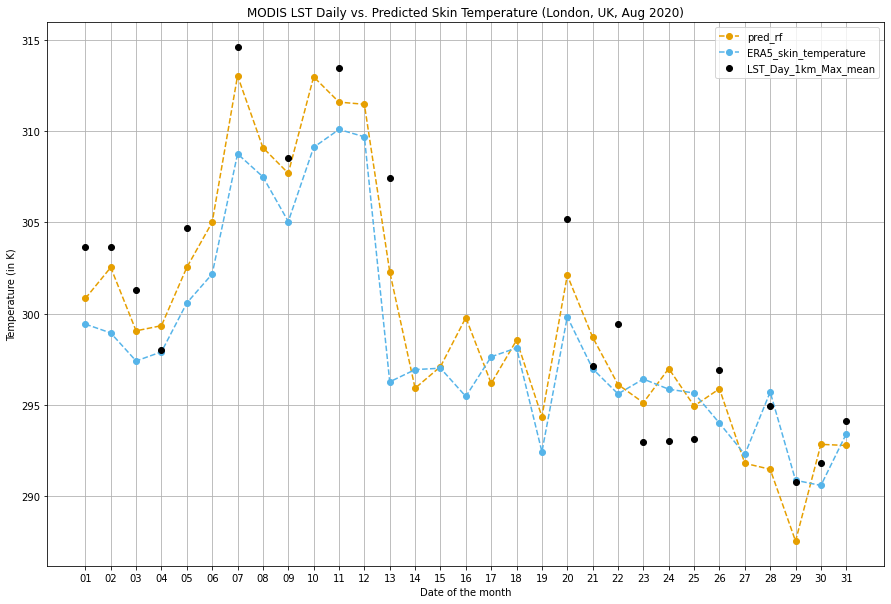

In [47]:
get_plot(plot_df, 'London, UK', '2020', '08', pred_cols=['pred_rf', 'ERA5_skin_temperature'])

## RMSE 

In [48]:
# df = pd.read_csv('/content/drive/MyDrive/ESOWC/preds/London_model_without_dropping_nan_for_test.csv')

df = y_test_df

print("RMSE LR: ", ((df.LST_Day_1km_Max_mean - df.pred_lr) ** 2).mean() ** .5)
print("RMSE DT: ", ((df.LST_Day_1km_Max_mean - df.pred_dt) ** 2).mean() ** .5)
print("RMSE RF: ", ((df.LST_Day_1km_Max_mean - df.pred_rf) ** 2).mean() ** .5)
print("RMSE XGB: ", ((df.LST_Day_1km_Max_mean - df.pred_xgb) ** 2).mean() ** .5)
# print("RMSE NN: ", ((df.LST_Day_1km_Max_mean - df.pred_nn) ** 2).mean() ** .5)

RMSE LR:  3.0532343140743237
RMSE DT:  4.065904634961742
RMSE RF:  3.224151127275299
RMSE XGB:  3.233929521078286


## Feature importances

In [49]:
temp = train_london_df.drop(columns=["LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature", "Location", 
                                     "datetime", "time_x", "Year", "Month", "Day", "DOY",])
features = np.array(temp.columns)

temp = []
for i in features:
  for j in range(6):
    temp.append(i+"_"+str(j))
features = np.array(temp)
print(features)

['tp_0' 'tp_1' 'tp_2' 'tp_3' 'tp_4' 'tp_5' 'cvl_0' 'cvl_1' 'cvl_2' 'cvl_3'
 'cvl_4' 'cvl_5' 'cvh_0' 'cvh_1' 'cvh_2' 'cvh_3' 'cvh_4' 'cvh_5' 'istl1_0'
 'istl1_1' 'istl1_2' 'istl1_3' 'istl1_4' 'istl1_5' 'slt_0' 'slt_1' 'slt_2'
 'slt_3' 'slt_4' 'slt_5' 'z_0' 'z_1' 'z_2' 'z_3' 'z_4' 'z_5' 'sp_0' 'sp_1'
 'sp_2' 'sp_3' 'sp_4' 'sp_5' 'sd_0' 'sd_1' 'sd_2' 'sd_3' 'sd_4' 'sd_5'
 'sdor_0' 'sdor_1' 'sdor_2' 'sdor_3' 'sdor_4' 'sdor_5' 'isor_0' 'isor_1'
 'isor_2' 'isor_3' 'isor_4' 'isor_5' 'anor_0' 'anor_1' 'anor_2' 'anor_3'
 'anor_4' 'anor_5' 'slor_0' 'slor_1' 'slor_2' 'slor_3' 'slor_4' 'slor_5'
 't2m_0' 't2m_1' 't2m_2' 't2m_3' 't2m_4' 't2m_5' 'd2m_0' 'd2m_1' 'd2m_2'
 'd2m_3' 'd2m_4' 'd2m_5' 'lsm_0' 'lsm_1' 'lsm_2' 'lsm_3' 'lsm_4' 'lsm_5'
 'fal_0' 'fal_1' 'fal_2' 'fal_3' 'fal_4' 'fal_5' 'albedo_0' 'albedo_1'
 'albedo_2' 'albedo_3' 'albedo_4' 'albedo_5' 'rad_0' 'rad_1' 'rad_2'
 'rad_3' 'rad_4' 'rad_5' 'wind_speed_0' 'wind_speed_1' 'wind_speed_2'
 'wind_speed_3' 'wind_speed_4' 'wind_speed_5']


In [ ]:
feature_importances = rf.feature_importances_

yx = zip(feature_importances, features)

yx = sorted(yx)

features_sorted = [x for y, x in yx]

feature_importances_sorted = [y for y, x in yx]


fig = plt.figure(figsize = (30, 5))
 
# creating the bar plot
plt.bar(features_sorted, feature_importances_sorted,
        width = 0.4)
plt.xticks(rotation = 90)
plt.show()

# sort_index = np.argsort(rf.feature_importances_)
# feature_importance_list = []
# for i in range(len(features)):
#   feature_importance_list.append(features[sort_index[i]])

# print(feature_importance_list)

# Training on Cabauw




In [51]:
cb_df = final_df.loc[final_df['Location'] == 'Cabauw, Netherlands']
cb_df = cb_df.loc[cb_df['Month'] == 2]
cb_df.head()

,datetime,Location,tp,cvl,cvh,istl1,slt,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal,albedo,rad,wind_speed,time_x,LST_Day_1km_Max_mean,LST_Day_1km_Max_mode,ERA5_skin_temperature,Year,Month,Day,DOY
2,2000-02-24,"Cabauw, Netherlands",0.000000,0.91909,0.064758,271.46020,3.0,-5.554199,102257.190,0.0,2.601685,0.630409,0.743268,0.000411,281.77870,274.95135,0.951235,0.137668,0.142020,2362204.16,5.521264,17:00:00,NaN,NaN,282.598572,2000,2,24,55
12,2000-02-25,"Cabauw, Netherlands",0.000000,0.91909,0.064758,271.46020,3.0,-5.554199,102920.440,0.0,2.601685,0.630409,0.743268,0.000411,281.04312,275.65520,0.951235,0.138341,0.142735,2439572.50,5.551821,17:00:00,281.390140,280.771026,281.937744,2000,2,25,56
22,2000-02-26,"Cabauw, Netherlands",0.000000,0.91909,0.064758,271.46020,3.0,-5.554199,103128.875,0.0,2.601685,0.630409,0.743268,0.000411,281.84088,275.61230,0.951235,0.139019,0.143441,2601590.70,3.370118,17:00:00,282.831428,282.860000,283.273621,2000,2,26,57
32,2000-02-27,"Cabauw, Netherlands",0.000000,0.91909,0.064758,271.46020,3.0,-5.554199,102141.750,0.0,2.601685,0.630409,0.743268,0.000411,285.18800,277.27365,0.951235,0.139697,0.144158,2533629.34,6.821322,17:00:00,NaN,NaN,284.722260,2000,2,27,58
42,2000-02-28,"Cabauw, Netherlands",0.002677,0.91909,0.064758,271.46045,3.0,-5.554199,101225.125,0.0,2.601685,0.630409,0.743268,0.000411,281.76465,280.15660,0.951235,0.140373,0.144872,1635216.50,7.330155,17:00:00,NaN,NaN,281.022949,2000,2,28,59


In [52]:
train_cb_df = cb_df.loc[cb_df.datetime.str.match(r'^2000|^2001|^2002|^2003|^2004|^2005|^2006|^2007|^2008|^2009|^2010|^2011|^2012|^2013|^2014|^2015|^2016|^2017|^2018')]
test_cb_df = cb_df.loc[cb_df.datetime.str.match(r'^2019|^2020|^2021')]

train_cb_df = train_cb_df.dropna().reset_index().drop(columns=["index"])
# test_london_df = test_london_df.dropna().reset_index().drop(columns=["index"])

In [53]:
print(len(train_cb_df))
print(len(test_cb_df))

262
85


In [55]:
y_train = np.array(train_cb_df['LST_Day_1km_Max_mean'])
X_train = np.array(train_cb_df.drop(columns=["LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature", "Location", "datetime", "time_x", "Year", "Month", "Day", "DOY",
                                                 ]))
y_test = np.array(test_cb_df['LST_Day_1km_Max_mean'])
X_test = np.array(test_cb_df.drop(columns=["LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature", "Location", "datetime", "time_x", "Year", "Month", "Day", "DOY",
                                               ]))

y_train_indices = train_cb_df[["Location", "datetime", "time_x", "LST_Day_1km_Max_mean", "ERA5_skin_temperature"]]
y_test_indices = test_cb_df[["Location", "datetime", "time_x", "LST_Day_1km_Max_mean", "ERA5_skin_temperature"]]

In [56]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(262, 19) (262,)
(85, 19) (85,)


In [57]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Unscaled data

In [58]:
lr = LinearRegression().fit(X_train, y_train)
pred_lr = lr.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_lr)))

In [59]:
dt = DecisionTreeRegressor(random_state=121).fit(X_train, y_train)
pred_dt = dt.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_dt)))

In [60]:
rf = RandomForestRegressor(random_state=121).fit(X_train, y_train)
pred_rf = rf.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_rf)))

In [61]:
xgb = XGBRegressor(max_depth=7, n_estimators=200, learning_rate=0.1, objective='reg:squarederror', random_state=121).fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_xgb)))

## Scaled data

In [62]:
lr = LinearRegression().fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_lr)))

In [63]:
dt = DecisionTreeRegressor(random_state=121).fit(X_train_scaled, y_train)
pred_dt = dt.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_dt)))

In [64]:
rf = RandomForestRegressor(random_state=121).fit(X_train_scaled, y_train)
pred_rf = rf.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_rf)))

In [65]:
xgb = XGBRegressor(max_depth=7, n_estimators=200, learning_rate=0.1, objective='reg:squarederror', random_state=121).fit(X_train_scaled, y_train)
pred_xgb = xgb.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_xgb)))

## Plotting results

In [66]:
y_test_df = y_test_indices
y_test_df['pred_lr'] = pred_lr
y_test_df['pred_dt'] = pred_dt
y_test_df['pred_rf'] = pred_rf
y_test_df['pred_xgb'] = pred_xgb

y_test_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Location,datetime,time_x,LST_Day_1km_Max_mean,ERA5_skin_temperature,pred_lr,pred_dt,pred_rf,pred_xgb
10912,"Cabauw, Netherlands",2019-02-01,17:00:00,NaN,276.819473,272.745998,275.677133,270.599459,268.455139
10922,"Cabauw, Netherlands",2019-02-02,17:00:00,262.735060,275.571838,269.065488,265.220039,265.752397,265.290375
10932,"Cabauw, Netherlands",2019-02-03,17:00:00,278.033251,279.446701,278.089860,278.866405,277.421614,277.708344
10942,"Cabauw, Netherlands",2019-02-04,17:00:00,NaN,276.646088,270.476873,259.920000,269.709129,265.843201
10952,"Cabauw, Netherlands",2019-02-05,17:00:00,NaN,278.900604,276.767447,268.386667,271.307366,270.894989


In [67]:
# y_test_df.to_csv("./drive/MyDrive/ESOWC/preds/Cabauw_model_without_dropping_nan_for_test.csv", index=False)

In [68]:
# plot_df = pd.read_csv("./drive/MyDrive/ESOWC/preds/London_model_without_dropping_nan_for_test.csv")
plot_df = y_test_df
plot_df['Year'] = plot_df['datetime'].apply(lambda x: x.split('-')[0])
plot_df['Month'] = plot_df['datetime'].apply(lambda x: x.split('-')[1])
plot_df['Day'] = plot_df['datetime'].apply(lambda x: x.split('-')[2])

plot_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Location,datetime,time_x,LST_Day_1km_Max_mean,ERA5_skin_temperature,pred_lr,pred_dt,pred_rf,pred_xgb,Year,Month,Day
10912,"Cabauw, Netherlands",2019-02-01,17:00:00,NaN,276.819473,272.745998,275.677133,270.599459,268.455139,2019,02,01
10922,"Cabauw, Netherlands",2019-02-02,17:00:00,262.735060,275.571838,269.065488,265.220039,265.752397,265.290375,2019,02,02
10932,"Cabauw, Netherlands",2019-02-03,17:00:00,278.033251,279.446701,278.089860,278.866405,277.421614,277.708344,2019,02,03
10942,"Cabauw, Netherlands",2019-02-04,17:00:00,NaN,276.646088,270.476873,259.920000,269.709129,265.843201,2019,02,04
10952,"Cabauw, Netherlands",2019-02-05,17:00:00,NaN,278.900604,276.767447,268.386667,271.307366,270.894989,2019,02,05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


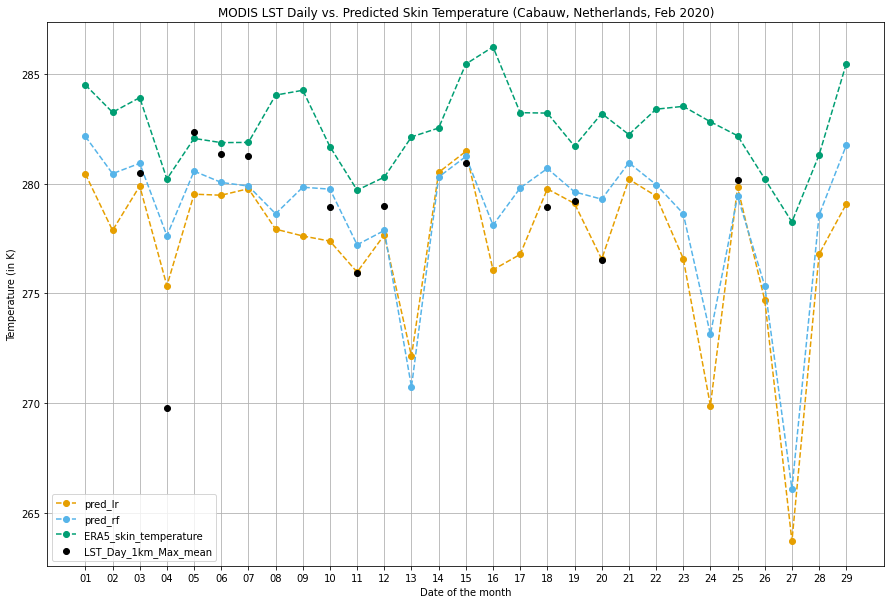

In [69]:
get_plot(plot_df, 'Cabauw, Netherlands', '2020', '02', pred_cols=['pred_lr', 'pred_rf', 'ERA5_skin_temperature'])

## RMSE 

In [70]:
# df = pd.read_csv('/content/drive/MyDrive/ESOWC/preds/London_model_without_dropping_nan_for_test.csv')

df = y_test_df

print("RMSE LR: ", ((df.LST_Day_1km_Max_mean - df.pred_lr) ** 2).mean() ** .5)
print("RMSE DT: ", ((df.LST_Day_1km_Max_mean - df.pred_dt) ** 2).mean() ** .5)
print("RMSE RF: ", ((df.LST_Day_1km_Max_mean - df.pred_rf) ** 2).mean() ** .5)
print("RMSE XGB: ", ((df.LST_Day_1km_Max_mean - df.pred_xgb) ** 2).mean() ** .5)
# print("RMSE NN: ", ((df.LST_Day_1km_Max_mean - df.pred_nn) ** 2).mean() ** .5)

RMSE LR:  4.473428122635113
RMSE DT:  6.095415289312146
RMSE RF:  4.541973763345755
RMSE XGB:  4.5049446474013335


# Training on all cities

In [71]:
train_df = final_df.loc[final_df.datetime.str.match(r'^2000|^2001|^2002|^2003|^2004|^2005|^2006|^2007|^2008|^2009|^2010|^2011|^2012|^2013|^2014|^2015|^2016|^2017|^2018')]
test_df = final_df.loc[final_df.datetime.str.match(r'^2019|^2020|^2021')]

train_df = train_df.dropna().reset_index().drop(columns=["index"])
# test_df = test_df.dropna().reset_index().drop(columns=["index"])

In [74]:
y_train = np.array(train_df['LST_Day_1km_Max_mean'])
X_train = np.array(train_df.drop(columns=["LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature", "Location", "datetime", "time_x", "Year", "Month", "Day", "DOY", "rad"]))

# X_train = np.array(train_df[['t2m', 'tp', 'd2m', 'fal', 'wind_speed', 'sp', 'albedo']])
y_test = np.array(test_df['LST_Day_1km_Max_mean'])
X_test = np.array(test_df.drop(columns=["LST_Day_1km_Max_mean", "LST_Day_1km_Max_mode", "ERA5_skin_temperature", "Location", "datetime", "time_x", "Year", "Month", "Day", "DOY", "rad"]))
# X_test = np.array(test_df[['t2m', 'tp', 'd2m', 'fal', 'wind_speed', 'sp', 'albedo']])


y_train_indices = train_df[["Location", "datetime", "time_x", "LST_Day_1km_Max_mean", "ERA5_skin_temperature"]]
y_test_indices = test_df[["Location", "datetime", "time_x", "LST_Day_1km_Max_mean", "ERA5_skin_temperature"]]

In [75]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7376, 18) (7376,)
(1470, 18) (1470,)


In [76]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Unscaled data

In [77]:
lr = LinearRegression().fit(X_train, y_train)
pred_lr = lr.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_lr)))

In [78]:
dt = DecisionTreeRegressor().fit(X_train, y_train)
pred_dt = dt.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_dt)))

In [79]:
rf = RandomForestRegressor().fit(X_train, y_train)
pred_rf = rf.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_rf)))

In [80]:
xgb = XGBRegressor(max_depth=7, objective='reg:squarederror').fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_xgb)))

In [81]:
nn = MLPRegressor(hidden_layer_sizes=(32, 16, 8), ).fit(X_train, y_train)
pred_nn = nn.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test, pred_nn)))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Scaled data

In [82]:
lr = LinearRegression().fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_lr)))

In [83]:
dt = DecisionTreeRegressor().fit(X_train_scaled, y_train)
pred_dt = dt.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_dt)))

In [84]:
rf = RandomForestRegressor().fit(X_train_scaled, y_train)
pred_rf = rf.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_rf)))

In [85]:
xgb = XGBRegressor(max_depth=7, n_estimators=200, learning_rate=0.1, objective='reg:squarederror').fit(X_train_scaled, y_train)
pred_xgb = xgb.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_xgb)))

In [86]:
nn = MLPRegressor(hidden_layer_sizes=(32, 32, 16), ).fit(X_train_scaled, y_train)
pred_nn = nn.predict(X_test_scaled)
# print(np.sqrt(mean_squared_error(y_test, pred_nn)))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Grid search CV

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 11.7min finished


{'bootstrap': True,
 'max_depth': 110,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 300}

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

best_grid = grid_search.best_estimator_

pred_best_rf = best_grid.predict(X_test_scaled)
# grid_accuracy = evaluate(best_grid, X_test_scaled, y_test)

## Feature Importance

In [ ]:
temp = train_df.drop(columns=["LST_Day_1km_Max_mean", "ERA5_skin_temperature", "Location", "datetime", "time_x"])
features = np.array(temp.columns)

temp = []
for i in features:
  for j in range(6):
    temp.append(i+"_"+str(j))
features = np.array(temp)
print(features)

In [ ]:
feature_importances = rf.feature_importances_

yx = zip(feature_importances, features)

yx = sorted(yx)

features_sorted = [x for y, x in yx]

feature_importances_sorted = [y for y, x in yx]


fig = plt.figure(figsize = (30, 5))
 
# creating the bar plot
plt.bar(features_sorted, feature_importances_sorted,
        width = 0.4)
plt.xticks(rotation = 90)
plt.show()

# sort_index = np.argsort(rf.feature_importances_)
# feature_importance_list = []
# for i in range(len(features)):
#   feature_importance_list.append(features[sort_index[i]])

# print(feature_importance_list)

In [ ]:
sort_index = np.argsort(rf.feature_importances_)
feature_importance_list = []
for i in range(len(features)):
  feature_importance_list.append(features[sort_index[i]])

print(feature_importance_list)

In [ ]:
xgb.feature_importances_

## Plotting results

In [87]:
y_test_df = y_test_indices
y_test_df['pred_lr'] = pred_lr
y_test_df['pred_dt'] = pred_dt
y_test_df['pred_rf'] = pred_rf
# y_test_df['pred_best_rf'] = pred_best_rf # pred_rf
y_test_df['pred_xgb'] = pred_xgb
y_test_df['pred_nn'] = pred_nn

y_test_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Location,datetime,time_x,LST_Day_1km_Max_mean,ERA5_skin_temperature,pred_lr,pred_dt,pred_rf,pred_xgb,pred_nn
10910,"Amsterdam, Netherlands",2019-02-01,17:00:00,NaN,276.571426,271.145722,278.013421,272.932628,273.230377,270.616549
10911,"Bugac, Hungary",2019-02-01,17:00:00,278.977806,280.286270,278.660402,274.732885,279.367078,279.400146,278.383974
10912,"Cabauw, Netherlands",2019-02-01,17:00:00,NaN,276.819473,270.438879,274.421391,272.986593,272.938080,271.720916
10913,"Espirra, Portugal",2019-02-01,17:00:00,284.209829,287.737442,284.300611,286.129623,284.001696,284.500061,283.970127
10914,"Falkenberg, Germany",2019-02-01,17:00:00,NaN,274.847794,270.435419,275.629810,274.648646,273.718536,270.318356


In [88]:
# y_test_df.to_csv("./drive/MyDrive/ESOWC/preds/Overall_model_without_dropping_nan_for_test.csv", index=False)

### Plotting model predictions vs. ground truth

In [89]:
# df = pd.read_csv('/content/drive/MyDrive/ESOWC/preds/Overall_model_without_dropping_nan_for_test.csv')

df = y_test_df 

df['Year'] = df['datetime'].apply(lambda x: x.split('-')[0])
df['Month'] = df['datetime'].apply(lambda x: x.split('-')[1])
df['Day'] = df['datetime'].apply(lambda x: x.split('-')[2])

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,Location,datetime,time_x,LST_Day_1km_Max_mean,ERA5_skin_temperature,pred_lr,pred_dt,pred_rf,pred_xgb,pred_nn,Year,Month,Day
10910,"Amsterdam, Netherlands",2019-02-01,17:00:00,NaN,276.571426,271.145722,278.013421,272.932628,273.230377,270.616549,2019,02,01
10911,"Bugac, Hungary",2019-02-01,17:00:00,278.977806,280.286270,278.660402,274.732885,279.367078,279.400146,278.383974,2019,02,01
10912,"Cabauw, Netherlands",2019-02-01,17:00:00,NaN,276.819473,270.438879,274.421391,272.986593,272.938080,271.720916,2019,02,01
10913,"Espirra, Portugal",2019-02-01,17:00:00,284.209829,287.737442,284.300611,286.129623,284.001696,284.500061,283.970127,2019,02,01
10914,"Falkenberg, Germany",2019-02-01,17:00:00,NaN,274.847794,270.435419,275.629810,274.648646,273.718536,270.318356,2019,02,01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


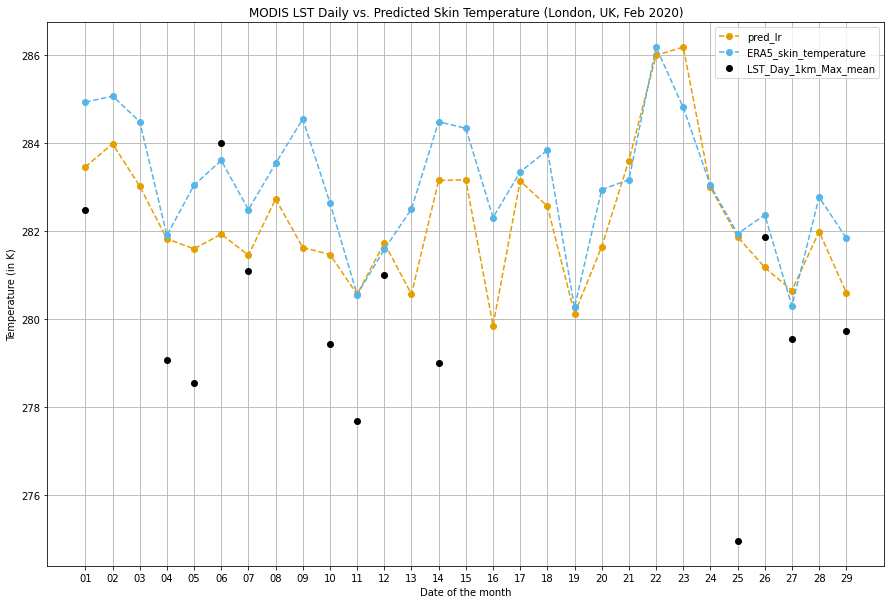

In [90]:
get_plot(df, 'London, UK', '2020', '02', pred_cols=['pred_lr', 'ERA5_skin_temperature'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


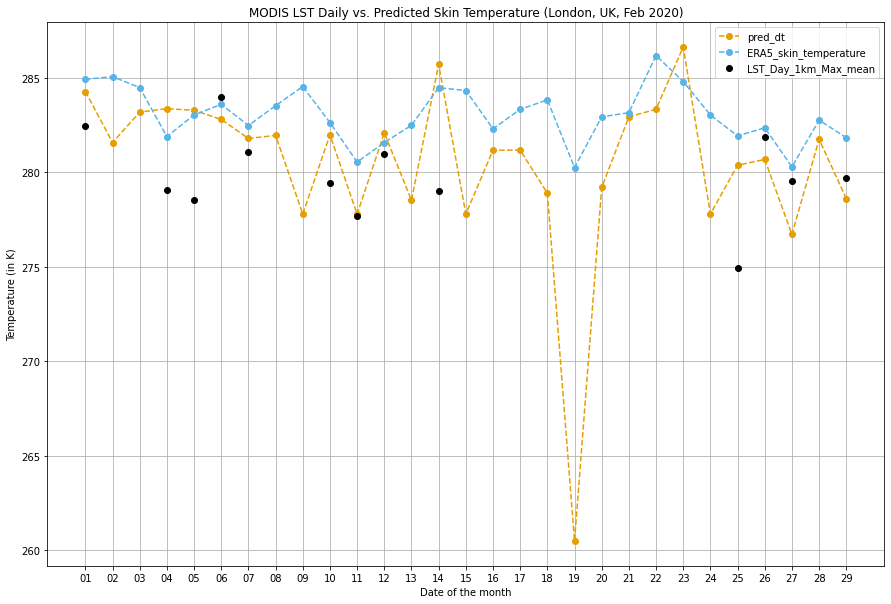

In [91]:
get_plot(df, 'London, UK', '2020', '02', pred_cols=['pred_dt', 'ERA5_skin_temperature'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


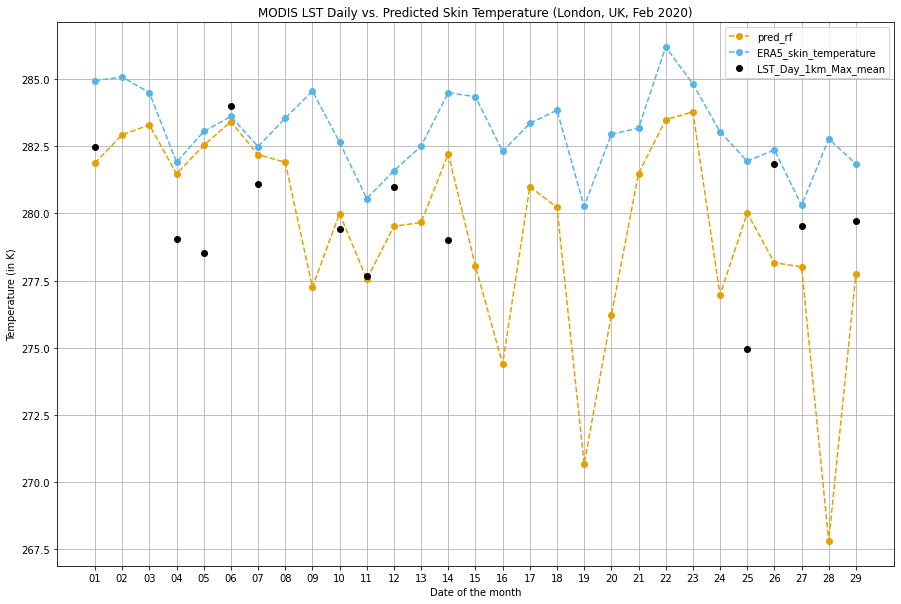

In [92]:
get_plot(df, 'London, UK', '2020', '02', pred_cols=['pred_rf', 'ERA5_skin_temperature'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


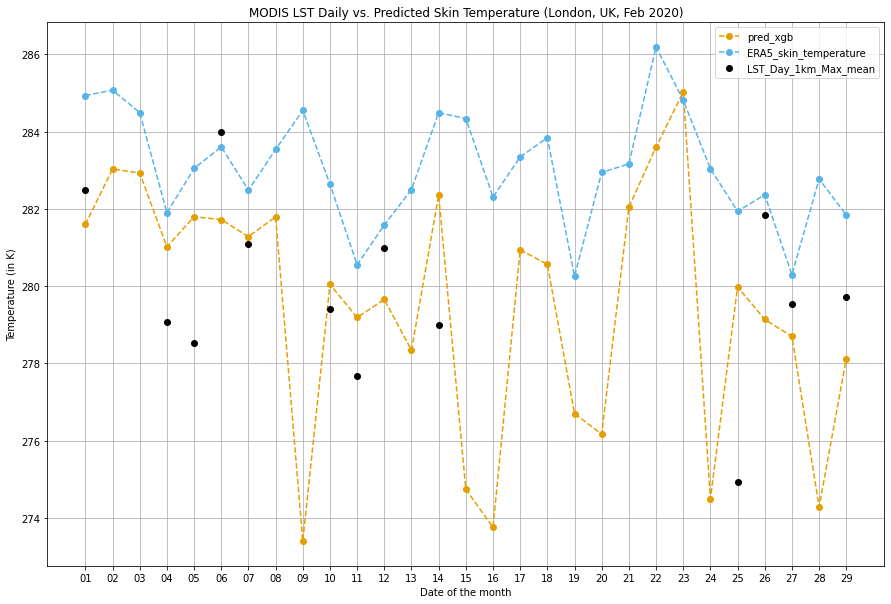

In [93]:
get_plot(df, 'London, UK', '2020', '02', pred_cols=['pred_xgb', 'ERA5_skin_temperature'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


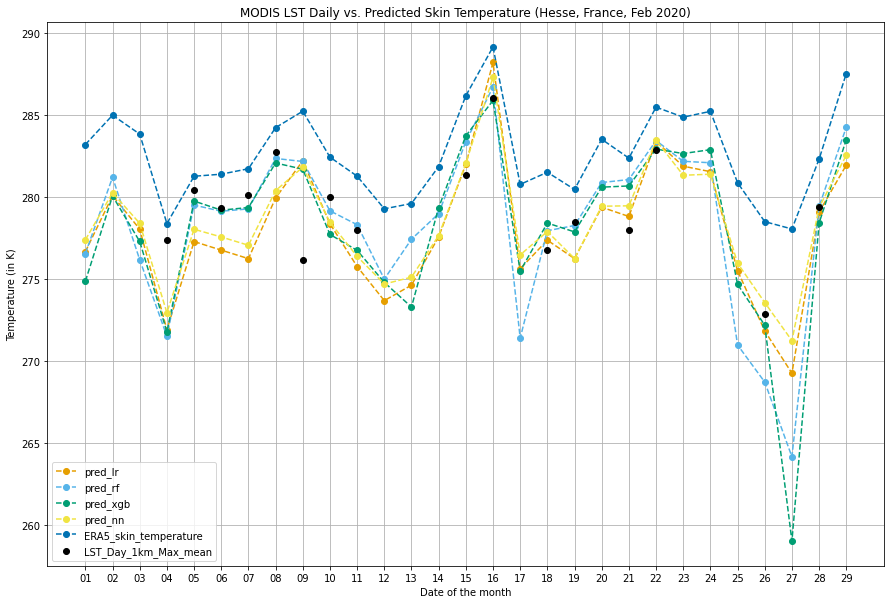

In [94]:
get_plot(df, 'Hesse, France', '2020', '02', pred_cols=['pred_lr','pred_rf', 'pred_xgb', 'pred_nn', 'ERA5_skin_temperature'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


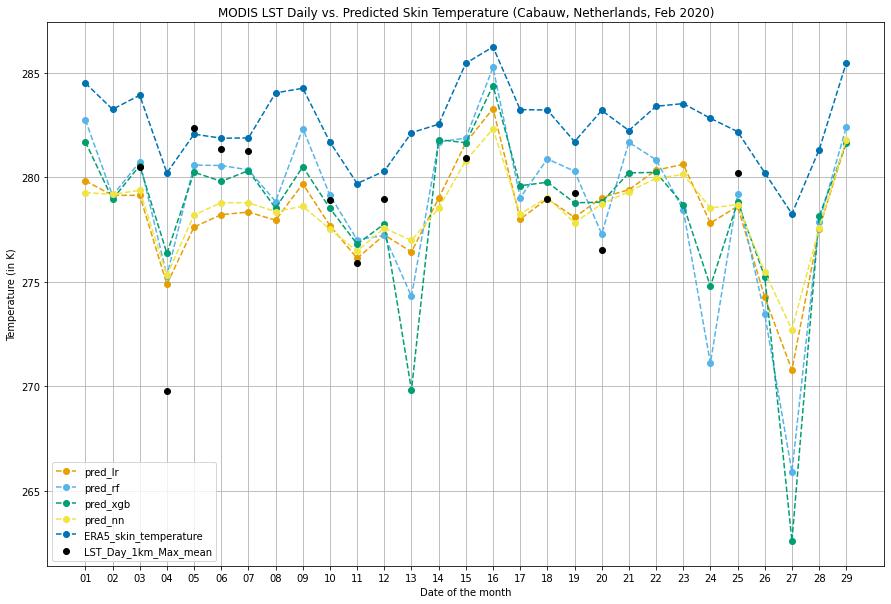

In [95]:
get_plot(df, 'Cabauw, Netherlands', '2020', '02', pred_cols=['pred_lr','pred_rf', 'pred_xgb', 'pred_nn', 'ERA5_skin_temperature'])

## Compute RMSE

In [96]:
# df = pd.read_csv('/content/drive/MyDrive/ESOWC/preds/Overall_model_without_dropping_nan_for_test.csv')

df = y_test_df

print("RMSE LR: ", ((df.LST_Day_1km_Max_mean - df.pred_lr) ** 2).mean() ** .5)
print("RMSE DT: ", ((df.LST_Day_1km_Max_mean - df.pred_dt) ** 2).mean() ** .5)
print("RMSE RF: ", ((df.LST_Day_1km_Max_mean - df.pred_rf) ** 2).mean() ** .5)
# print("RMSE BEST_RF: ", ((df.LST_Day_1km_Max_mean - df.pred_best_rf) ** 2).mean() ** .5)
print("RMSE XGB: ", ((df.LST_Day_1km_Max_mean - df.pred_xgb) ** 2).mean() ** .5)
print("RMSE NN: ", ((df.LST_Day_1km_Max_mean - df.pred_nn) ** 2).mean() ** .5)

RMSE LR:  3.1984706457391807
RMSE DT:  4.161712158420517
RMSE RF:  2.9797327623043626
RMSE XGB:  2.9238217552605463
RMSE NN:  3.1862458623394816


# Plotting distributions of different variables

In [ ]:
final_df.head()

,datetime,Location,tp,cvl,cvh,istl1,slt,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal,albedo,rad,wind_speed,time_x,LST_Day_1km_Max_mean,LST_Day_1km_Max_mode,ERA5_skin_temperature,Year,Month,Day,DOY
0,2000-02-24,"Amsterdam, Netherlands",0.000000,0.745840,0.119293,271.4602,3.0,-18.481934,102196.690,0.000000,2.454651,0.417521,-0.172062,0.000511,280.98670,275.53827,0.825991,0.112277,0.118859,2413525.56,6.903876,17:00:00,NaN,NaN,282.543884,2000,2,24,55
1,2000-02-24,"Bugac, Hungary",0.000054,0.703821,0.296179,271.4602,1.0,993.469240,101723.125,0.000064,5.271973,0.340797,0.036897,0.000786,276.50067,271.34464,0.987635,0.153323,0.150202,2232757.50,2.018375,17:00:00,NaN,NaN,279.808060,2000,2,24,55
2,2000-02-24,"Cabauw, Netherlands",0.000000,0.919090,0.064758,271.4602,3.0,-5.554199,102257.190,0.000000,2.601685,0.630409,0.743268,0.000411,281.77870,274.95135,0.951235,0.137668,0.142020,2362204.16,5.521264,17:00:00,NaN,NaN,282.598572,2000,2,24,55
3,2000-02-24,"Espirra, Portugal",0.000000,0.433064,0.539948,271.4602,1.0,856.137200,101693.625,0.000000,22.107788,0.659839,-0.915545,0.003944,295.88544,281.49954,0.991366,0.154025,0.155025,3593100.20,4.342252,17:00:00,NaN,NaN,297.655441,2000,2,24,55
4,2000-02-24,"Falkenberg, Germany",0.001977,0.130242,0.869758,271.4602,2.0,559.787600,101211.625,0.000000,13.955505,0.473701,0.070932,0.002836,278.80713,277.77753,0.979079,0.139606,0.128207,1871253.50,4.786656,17:00:00,NaN,NaN,277.919388,2000,2,24,55


In [ ]:
import seaborn as sns

In [ ]:
temp_df = final_df.loc[final_df['Location'] == 'Cabauw, Netherlands']
temp_df = temp_df.loc[temp_df['Month'] == 8]
temp_df.head()

,datetime,Location,tp,cvl,cvh,istl1,slt,z,sp,sd,sdor,isor,anor,slor,t2m,d2m,lsm,fal,albedo,rad,wind_speed,time_x,LST_Day_1km_Max_mean,LST_Day_1km_Max_mode,ERA5_skin_temperature,Year,Month,Day,DOY
62,2000-08-01,"Cabauw, Netherlands",0.001114,0.91909,0.064758,271.46042,3.0,-5.554199,101721.250,0.0,2.601685,0.630409,0.743268,0.000411,299.99194,290.53198,0.951235,0.171557,0.177366,3591980.4,3.556770,17:00:00,301.512379,301.315944,299.772217,2000,8,1,214
72,2000-08-02,"Cabauw, Netherlands",0.000224,0.91909,0.064758,271.46014,3.0,-5.554199,101572.440,0.0,2.601685,0.630409,0.743268,0.000411,294.53710,286.84570,0.951235,0.171605,0.177412,3939315.5,5.702975,17:00:00,295.151462,295.075294,295.538330,2000,8,2,215
82,2000-08-03,"Cabauw, Netherlands",0.002728,0.91909,0.064758,271.46024,3.0,-5.554199,101524.440,0.0,2.601685,0.630409,0.743268,0.000411,293.93628,287.78810,0.951235,0.171638,0.177455,3535249.7,3.220135,17:00:00,295.892563,296.029455,295.648682,2000,8,3,216
92,2000-08-04,"Cabauw, Netherlands",0.000480,0.91909,0.064758,271.46017,3.0,-5.554199,102137.440,0.0,2.601685,0.630409,0.743268,0.000411,293.38428,288.87110,0.951235,0.171679,0.177497,3777020.0,2.956940,17:00:00,292.186239,290.261333,295.629150,2000,8,4,217
102,2000-08-05,"Cabauw, Netherlands",0.000078,0.91909,0.064758,271.46027,3.0,-5.554199,102446.375,0.0,2.601685,0.630409,0.743268,0.000411,294.41090,287.19970,0.951235,0.171727,0.177543,2960979.5,2.653646,17:00:00,297.347790,297.064444,295.485596,2000,8,5,218


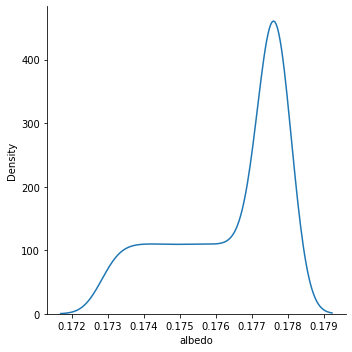

In [ ]:
sns.displot(temp_df, x='albedo', kind='kde',) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa319f1d890>]],
      dtype=object)

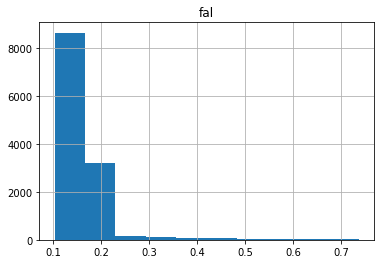

In [ ]:
final_df[['fal']].hist()

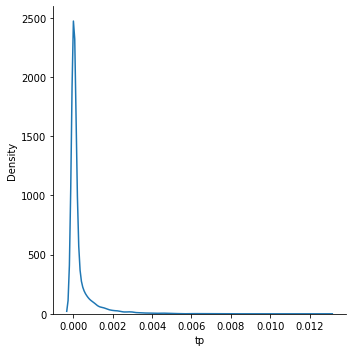

In [ ]:
sns.displot(final_df, x='tp', kind='kde',) # bw_adjust=0.1)

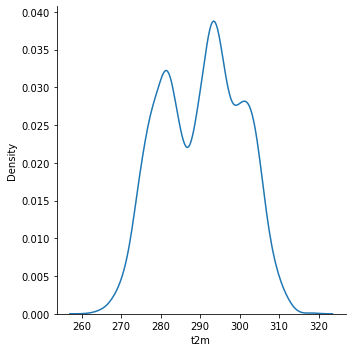

In [ ]:
sns.displot(final_df, x='t2m', kind='kde',) #bw_adjust=0.1)

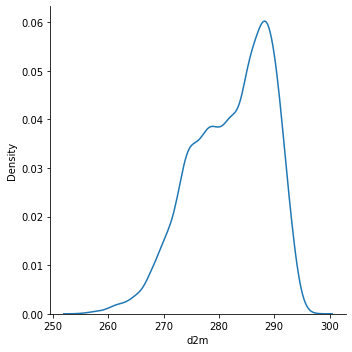

In [ ]:
sns.displot(final_df, x='d2m', kind='kde',) #bw_adjust=0.1)

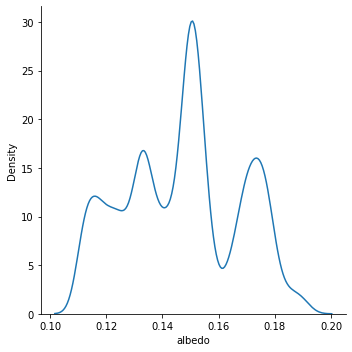

In [ ]:
sns.displot(final_df, x='albedo', kind='kde',) #bw_adjust=0.1)

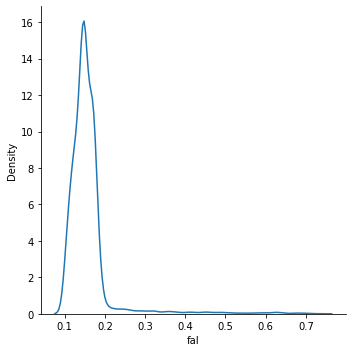

In [ ]:
sns.displot(final_df, x='fal', kind='kde',) # bw_adjust=0.1)

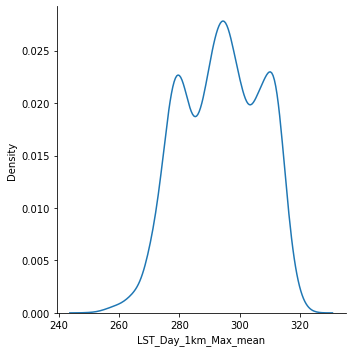

In [ ]:
sns.displot(final_df, x='LST_Day_1km_Max_mean', kind='kde',) # bw_adjust=0.1)

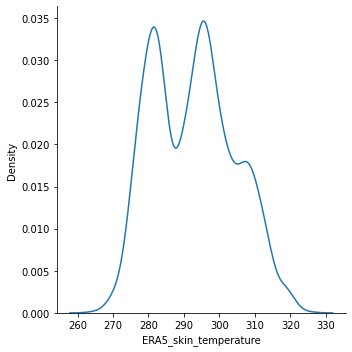

In [ ]:
import seaborn as sns
sns.displot(final_df, x='ERA5_skin_temperature', kind='kde',) # bw_adjust=0.1)